# SALMO plots

In this notebook all plots from the SALMO simulations are collected.

In [54]:
### paths
nside = 1024
pathSALMO = f'/vol/aleph/data/mheld/salmo/SALMO_simulations/trueVD_{nside}/'
pathFIGS_SALMO = f'../figs_thesis/trueVD_{nside}/'

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pandas as pd
import os
import pymaster as nmt
import matplotlib as mpl
from tqdm import tqdm
import matplotlib

### define templates names
temps_names = ['$n_{star}$', 'completeness', 'extinction']
keys_names = ['$n_\\mathrm{star} / \\langle n_\\mathrm{star}\\rangle$', 'Completeness', 'E(B-V)']


maskSALMO = hp.ud_grade(hp.read_map(f'../maps_for_salmo/DECALS_mask.fits'), nside)

savefigs = True

Nsim = 100

deprojection_bias_cls = np.load(f'../theory/depbias_multi.npy')

b = np.append(2**(np.arange(int(np.log(2*nside) / np.log(2)+1)))[1:], 3*nside)
bins = nmt.NmtBin.from_edges(b[:-1], b[1:])
ells = bins.get_effective_ells()

## workspace4
wsp = nmt.NmtWorkspace()
f = nmt.NmtField(maskSALMO, None, spin=0)
wsp.compute_coupling_matrix(f,f, bins)

nbands = 8
lmax = 2*nside
dell = lmax // nbands



In [2]:
mpl.rcParams["font.size"] = 16
mpl.rcParams["legend.fontsize"] = 16

In [5]:
a_sys = -0.0298
a_sys = 1

#### Galaxy maps and simulated mean number density

100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


------------------------------------------------------------
Simulation wo VD:
--------------------
simulated mean number density: 0.0093999
------------------------------------------------------------
Simulation w VD:
--------------------
observed mean number density: 0.0093984
------------------------------------------------------------


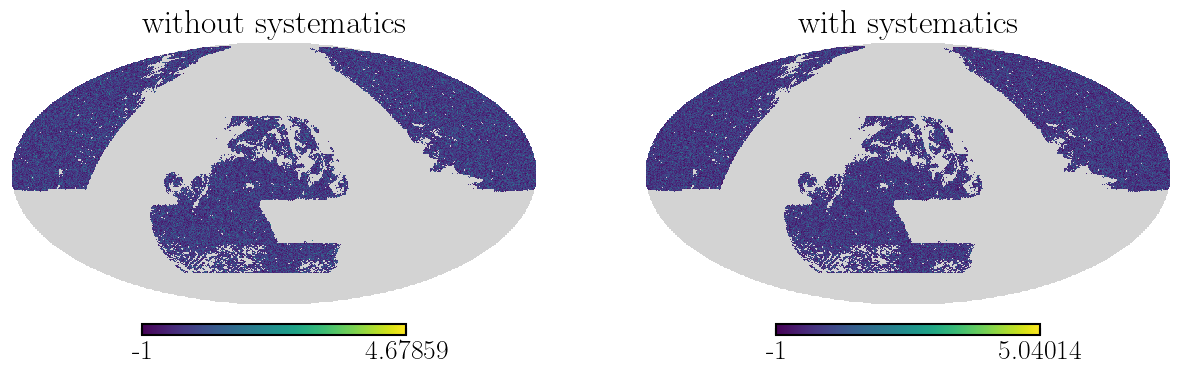

In [6]:
def CreateNumDens(galmap, mask):
    n_mean = np.sum(galmap[np.where(mask!=0)[0]]) / len(np.where(mask!=0)[0])
    n_dens_gals = galmap/n_mean
    return n_dens_gals, n_mean

def mask_map(map, mask):
    copy = map.copy()
    copy[mask==0] = np.nan
    return copy


PixelArea = hp.nside2pixarea(nside, degrees=True)*60*60  ## in arcmin²
NmeanSim0 = 0
NmeanSim1 = 0
for i in tqdm(range(1)):
    GalCount0 = hp.read_map(f'{pathSALMO}GalMaps/GalCount_{i+1}_type0.fits')
    GalCount1 = hp.read_map(f'{pathSALMO}GalMaps/GalCount_{i+1}_type1.fits')

    DensMap0, nmean0 = CreateNumDens(GalCount0, maskSALMO)
    DensMap1, nmean1 = CreateNumDens(GalCount1, maskSALMO)
    
    ### number density of simulated galaxies:
    NmeanSim0 += nmean0 /PixelArea
    NmeanSim1 += nmean1 /PixelArea

NmeanSim0 = NmeanSim0/100
NmeanSim1 = NmeanSim1/100

print('------------------------------------------------------------')
print('Simulation wo VD:')
print('--------------------')
print(f'simulated mean number density: {round(NmeanSim0, 7)}')
print('------------------------------------------------------------')
print('Simulation w VD:')
print('--------------------')
print(f'observed mean number density: {round(NmeanSim1, 7)}')
print('------------------------------------------------------------')

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,4.5))
matplotlib.rcParams.update({'font.size':20})

plt.axes(ax[0])
hp.mollview(mask_map(GalCount0 / nmean0 -1, maskSALMO), hold=True, title='without systematics', badcolor='lightgrey')

fig = plt.gcf()  # Get current figure
cbar = fig.axes[-1]  # The last axis is usually the colorbar
cbar.tick_params(labelsize=20)  # Set the fontsize of colorbar ticks
plt.axes(ax[1])
hp.mollview(mask_map(GalCount1 / nmean1-1, maskSALMO), hold=True, title='with systematics', badcolor='lightgrey')

fig = plt.gcf()  # Get current figure
cbar = fig.axes[-1]  # The last axis is usually the colorbar
cbar.tick_params(labelsize=20)  # Set the fontsize of colorbar ticks

if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}ngal_maps.png')
plt.show()

#### Reshift distribution

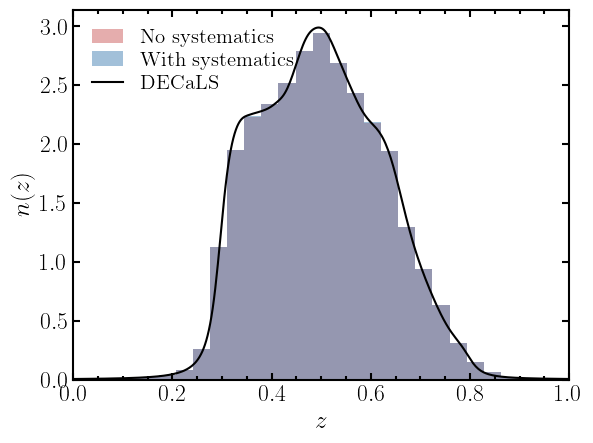

In [7]:
### plot redshift distribution

path_z = f'{pathSALMO}redshifts/'

z0 = np.load(f'{path_z}z0_1.npy')
z1 = np.load(f'{path_z}z1_1.npy')


plt.hist(z0, bins=np.linspace(0,1,30), density=True, color='indianred', label='No systematics', alpha=0.5)
plt.hist(z1, bins=np.linspace(0,1,30), density=True, color='steelblue', label='With systematics', alpha=0.5)

z_dels = np.load('../data_DELS/z.npy')
nz_dels = np.load('../data_DELS/nz.npy')

plt.plot(z_dels, nz_dels, color='black', label='DECaLS')
plt.xlabel('$z$')
plt.ylabel('$n(z)$')
plt.legend(loc='upper left', frameon=False, fontsize=15)
plt.xlim(0,1)
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}/redshift_distribution.png')
plt.show()

#### Systematics relations

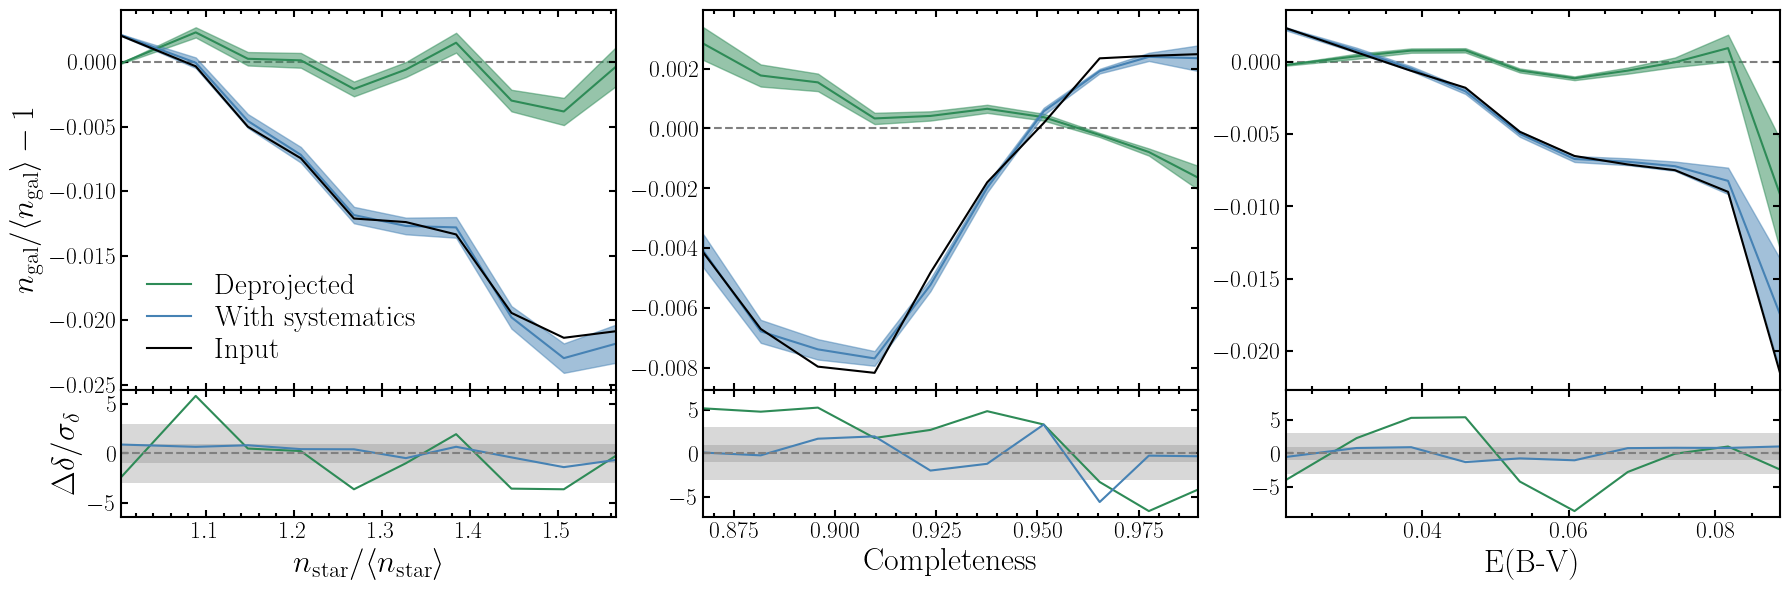

In [17]:
sysrel = pd.read_csv(f'{pathSALMO}sysrels/mean_systematic_relations.data')

sysrels_save = []

fig = plt.figure(figsize=(6*len(temps_names), 6))
bands_grid = fig.add_gridspec(1,len(temps_names))


for i, name in enumerate(temps_names):
    plots_grid = bands_grid[i].subgridspec(2,1,hspace=0, height_ratios=[3,1])
    ax, ax2 = plots_grid.subplots()
    
    temp_vals = sysrel[f"{name}"].to_numpy()
    ax.plot(temp_vals , sysrel[f"Deprojected: {name}: ngals"], label='Deprojected', color='seagreen')
    ax.fill_between(temp_vals, sysrel[f"Deprojected: {name}: ngals"] - sysrel[f"Deprojected: {name}: ngals unc"], sysrel[f"Deprojected: {name}: ngals"] + sysrel[f"Deprojected: {name}: ngals unc"], alpha=0.5, color='seagreen')
    #ax.plot(temp_vals , sysrel[f"Reweighted: {name}: ngals"], label='Reweighted', color='orange')
    #ax.fill_between(temp_vals, sysrel[f"Reweighted: {name}: ngals"] - sysrel[f"Reweighted: {name}: ngals unc"], sysrel[f"Reweighted: {name}: ngals"] + sysrel[f"Reweighted: {name}: ngals unc"], alpha=0.5, color='orange')
    ax.plot(temp_vals, sysrel[f"VD: {name}: ngals"], label='With systematics', color='steelblue')
    ax.fill_between(temp_vals, sysrel[f"VD: {name}: ngals"] - sysrel[f"VD: {name}: ngals unc"], sysrel[f"VD: {name}: ngals"] + sysrel[f"VD: {name}: ngals unc"], alpha=0.5, color='steelblue')
    

    ax.plot(temp_vals, a_sys*sysrel[f"Input: {name}: ngals"]-1, label='Input', color='black', ls='-')
    
    ax.axhline(0, color='grey', zorder=0, ls='--')
    
    ax.set_xlim(temp_vals[0], temp_vals[-1])
    
    rel_dep = (sysrel[f"Deprojected: {name}: ngals"].to_numpy()-0)/ sysrel[f"Deprojected: {name}: ngals unc"].to_numpy()
    rel_sys = (sysrel[f"VD: {name}: ngals"].to_numpy()- sysrel[f"Input: {name}: ngals"]+1)/ sysrel[f"VD: {name}: ngals unc"].to_numpy()
    rel_rew = np.array([0])
    ax2.plot(temp_vals , rel_dep, color='seagreen')
    ax2.plot(temp_vals , rel_sys, color='steelblue')
    ax2.fill_between(y1=-1, y2=1, x=temp_vals, alpha=0.3, color='grey', edgecolor=None)
    ax2.fill_between(y1=-3, y2=3, x=temp_vals, alpha=0.3, color='grey', edgecolor=None)
    ax2.set_xlim(temp_vals[0], temp_vals[-1])
    ax2.set_ylim(min(-5, -max(abs(rel_dep))*1.1, - max(abs(rel_rew))*1.1), max(5, max(abs(rel_dep))*1.1, max(abs(rel_rew))*1.1))
    ax2.set_xlabel(keys_names[i], fontsize=23)
    ax2.axhline(0,ls='--', color='grey')
    if i == 0:
        ax.legend(loc='lower left',frameon=False, fontsize=21)  
        ax.set_ylabel('$n_\\mathrm{gal} / \\langle n_\\mathrm{gal}\\rangle - 1$', fontsize=23) 
        ax2.set_ylabel('$\\Delta \\delta / \\sigma_\\delta$', fontsize=23)
plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}sysrels.png')
plt.show()


#### Cls of SALMO

In [9]:
cls_true = np.load('../theory/cls_theory_ccl.npy')
cls_theo = wsp.decouple_cell(wsp.couple_cell([cls_true]))[0]   ## coupled/decoupled power spectrum

1


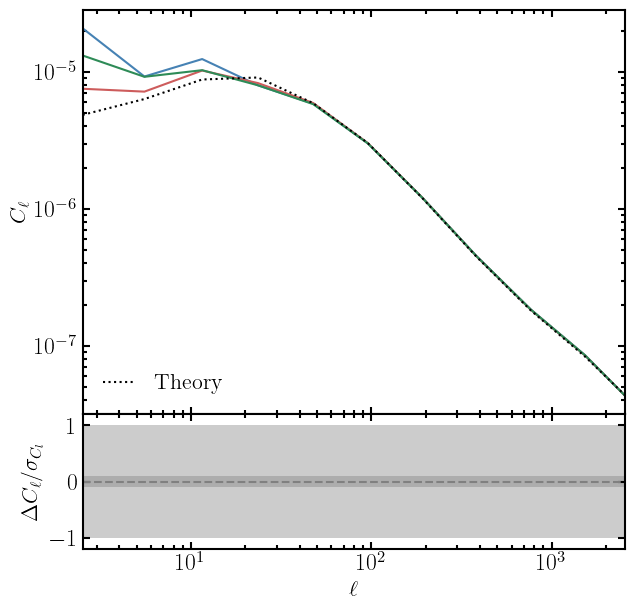

2


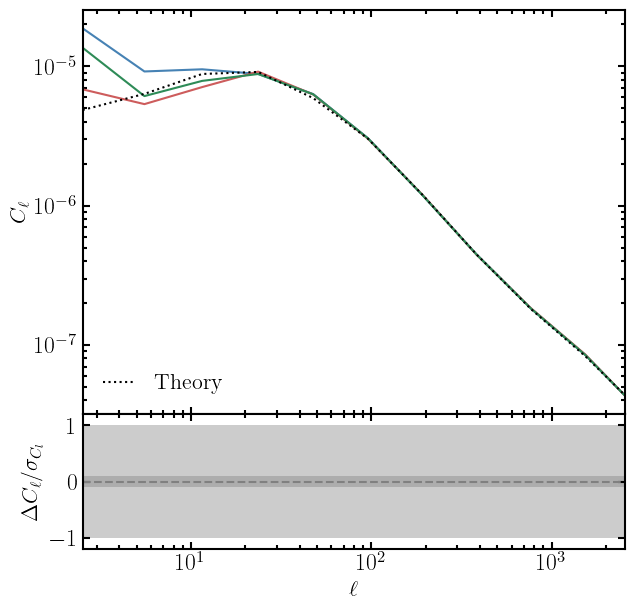

3


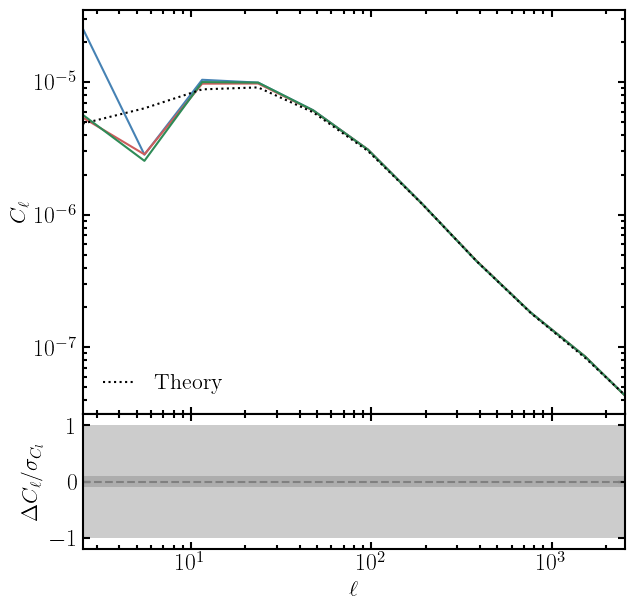

4


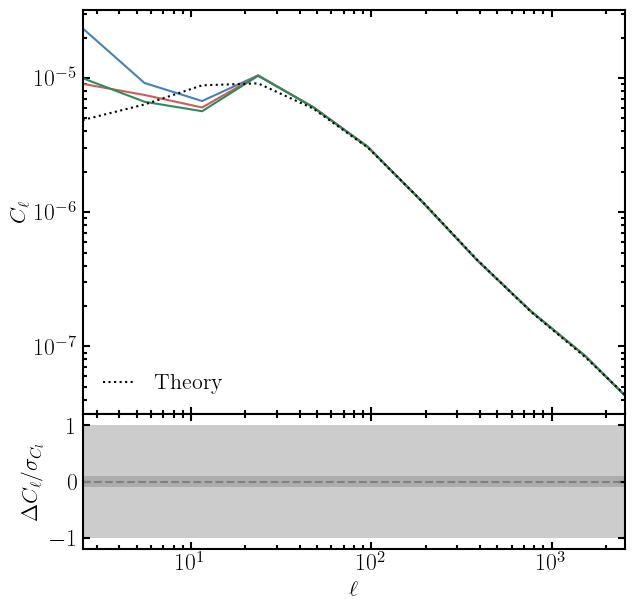

5


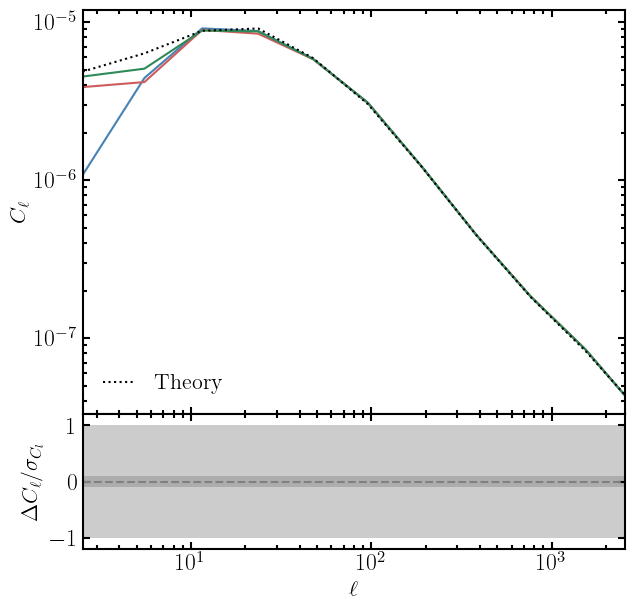

6


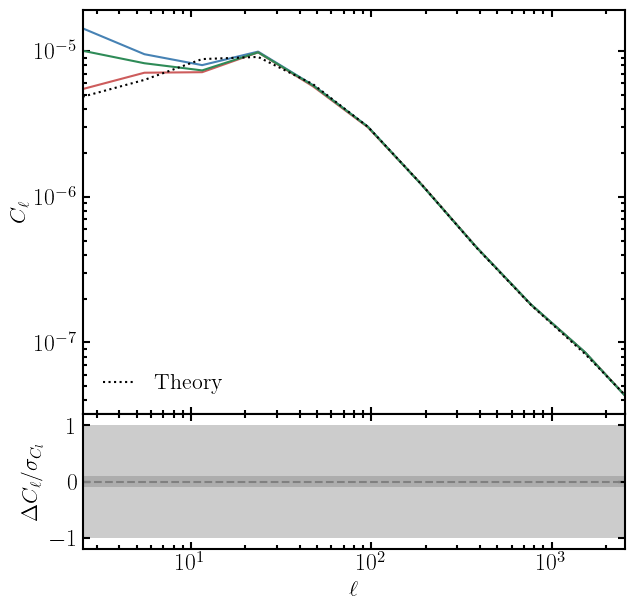

7


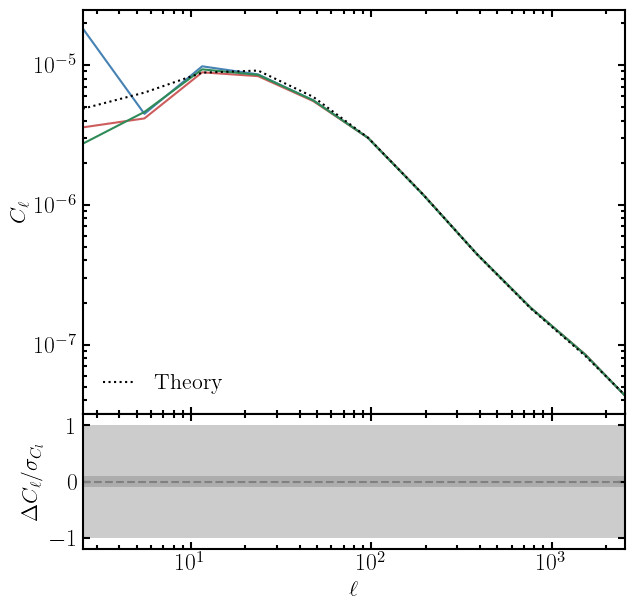

8


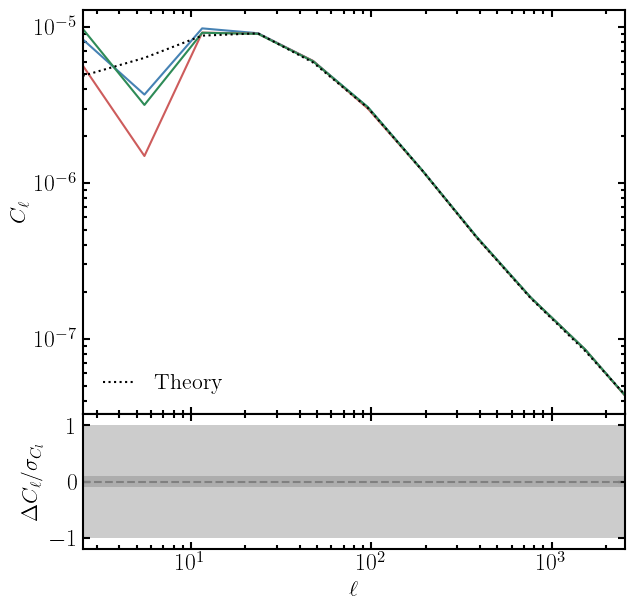

9


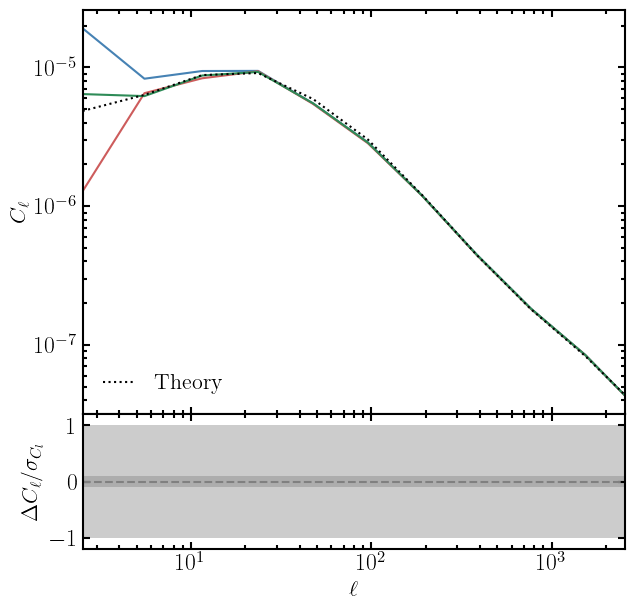

10


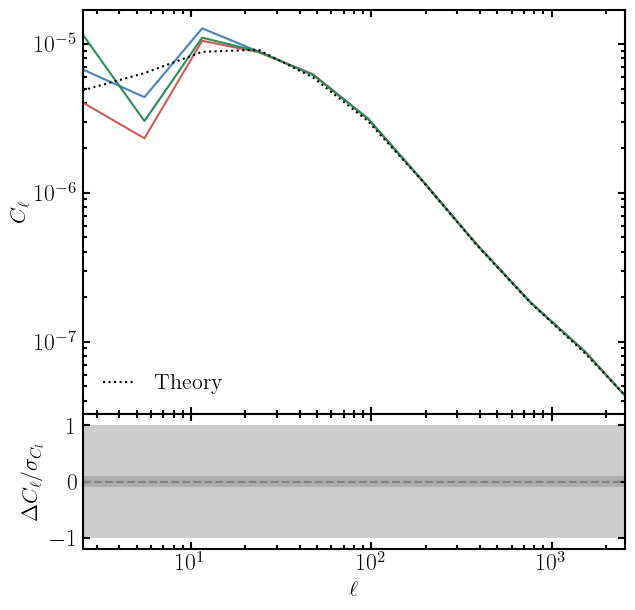

11


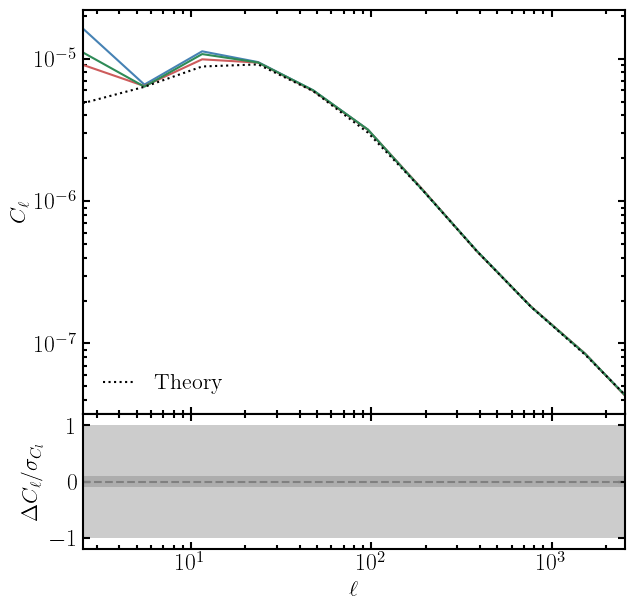

12


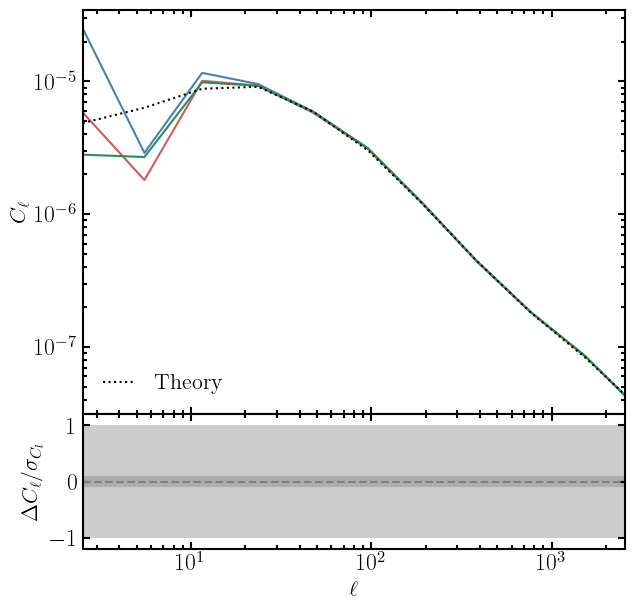

13


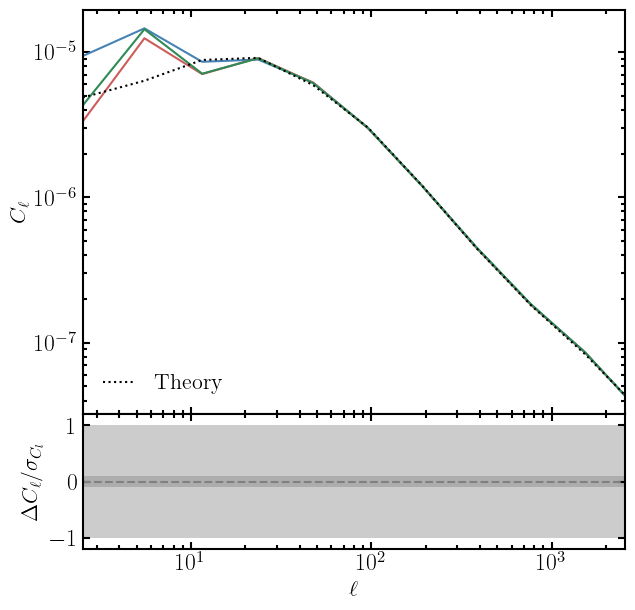

14


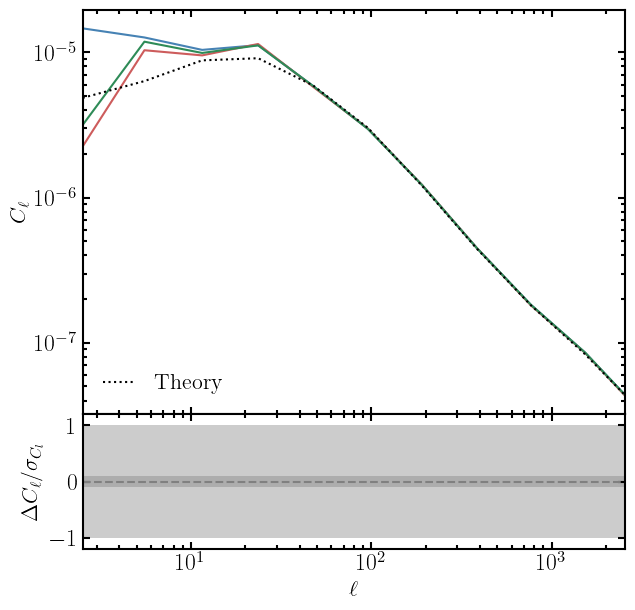

15


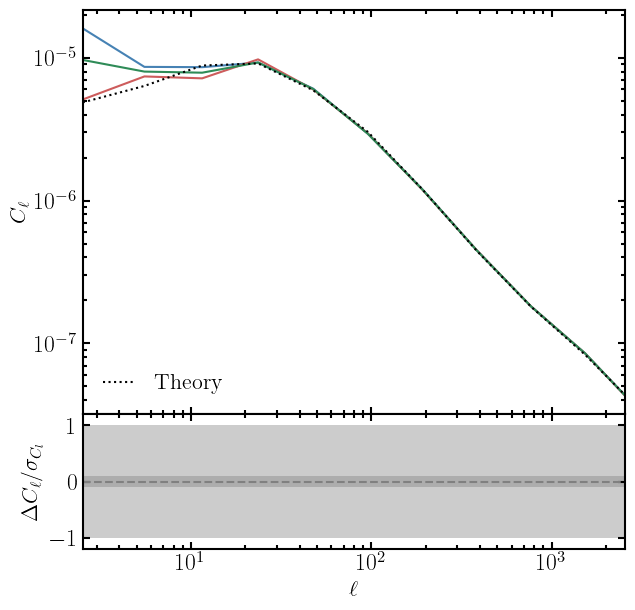

16


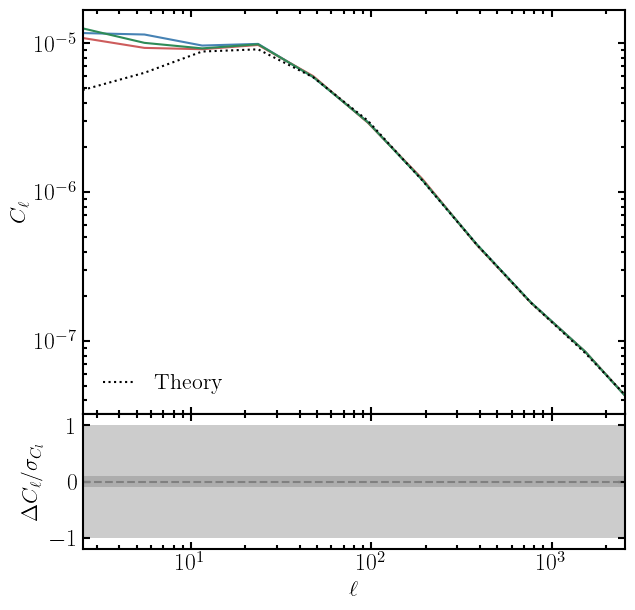

17


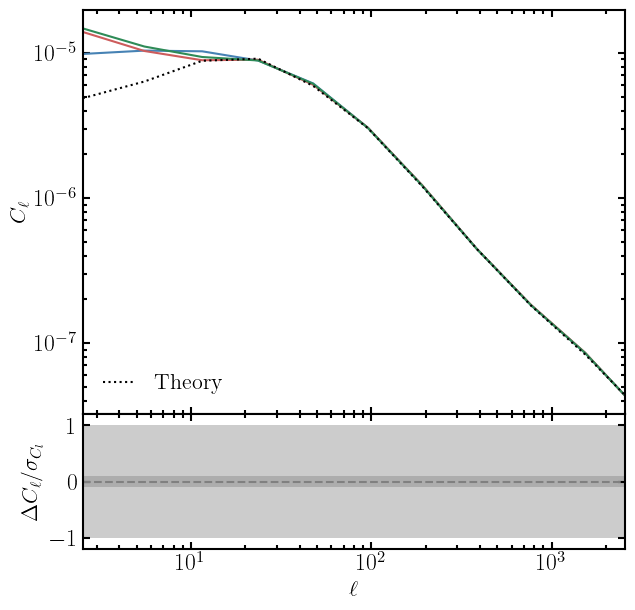

18


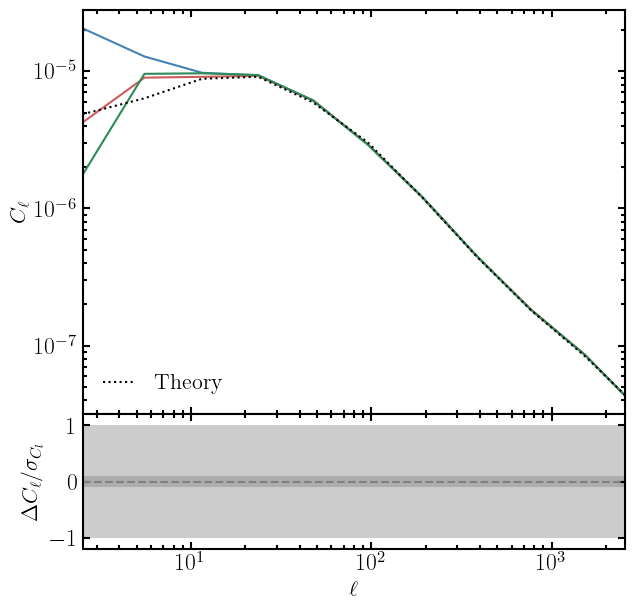

19


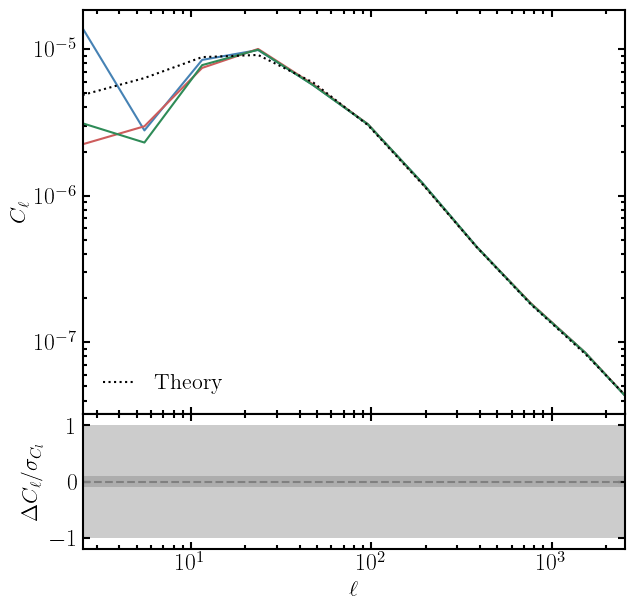

20


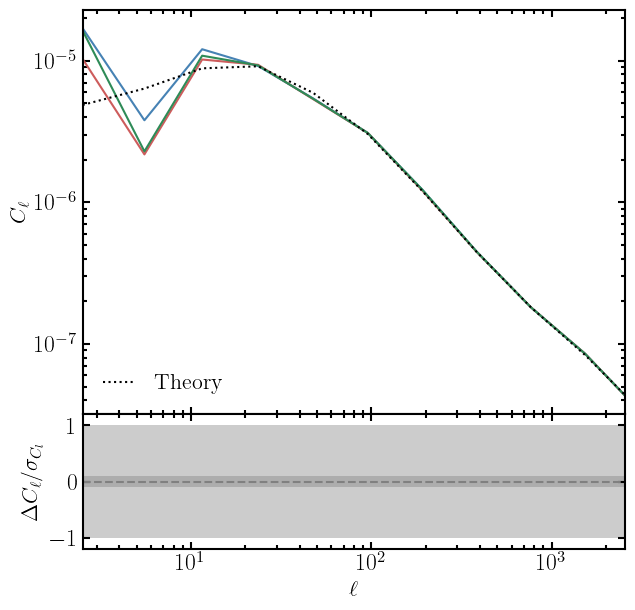

21


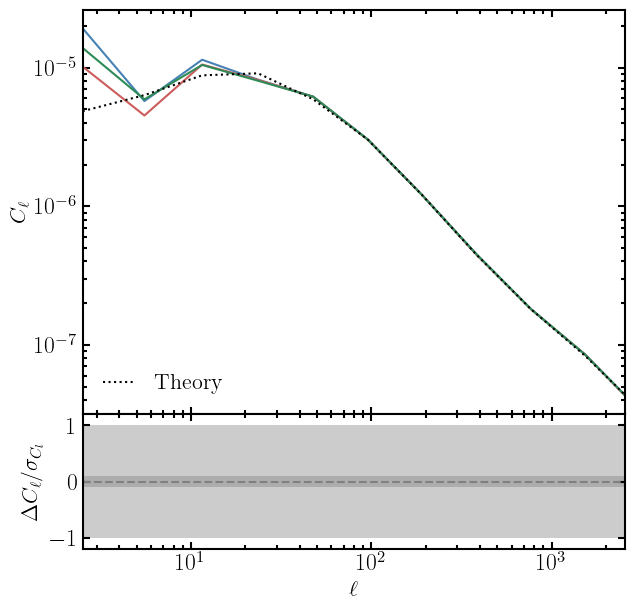

22


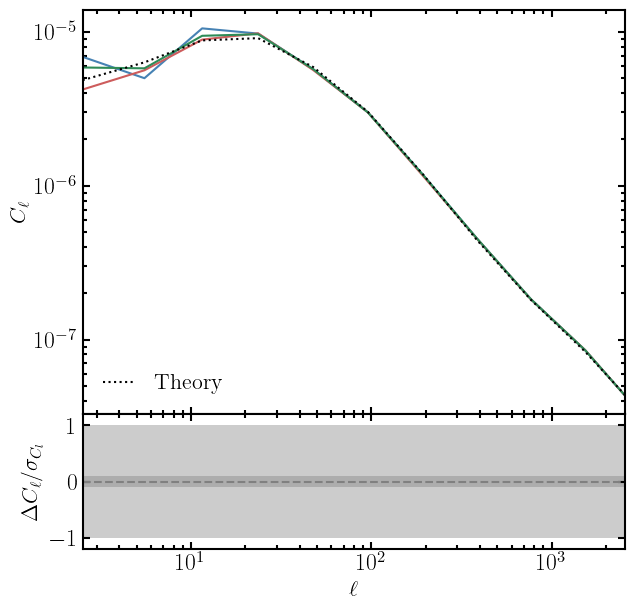

23


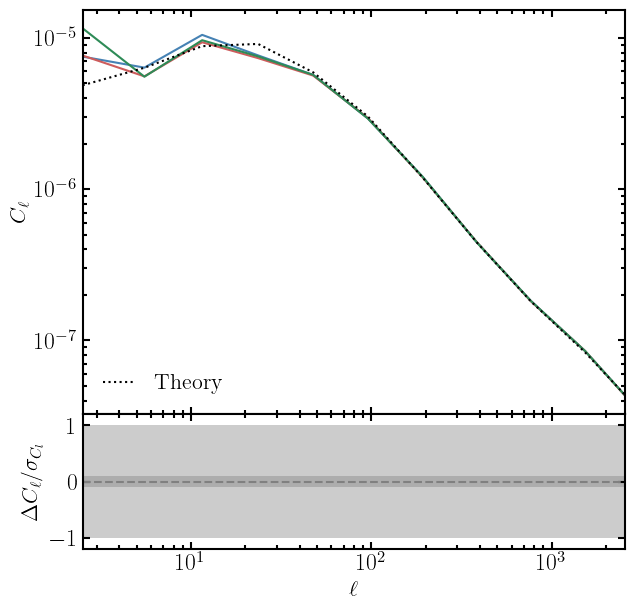

24


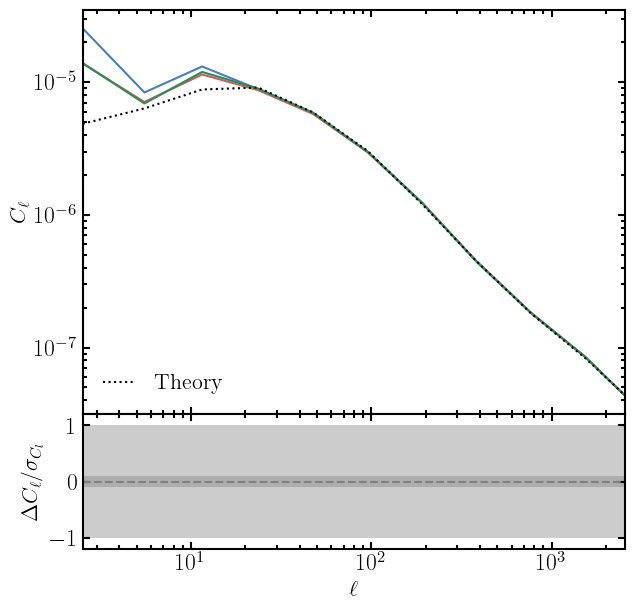

25


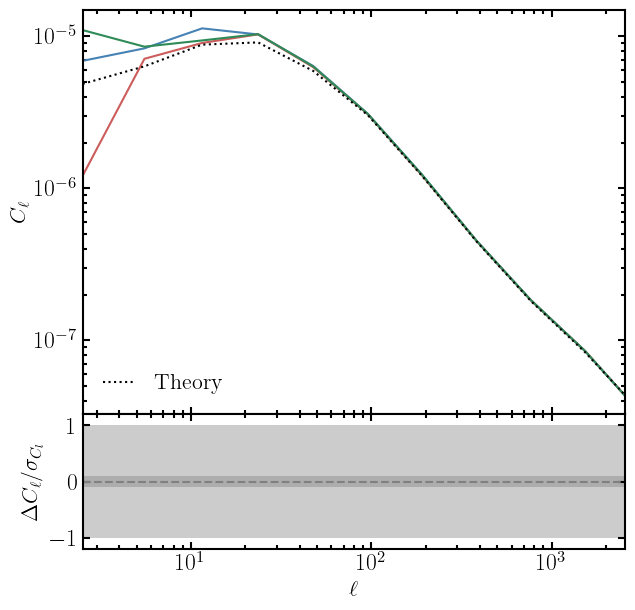

26


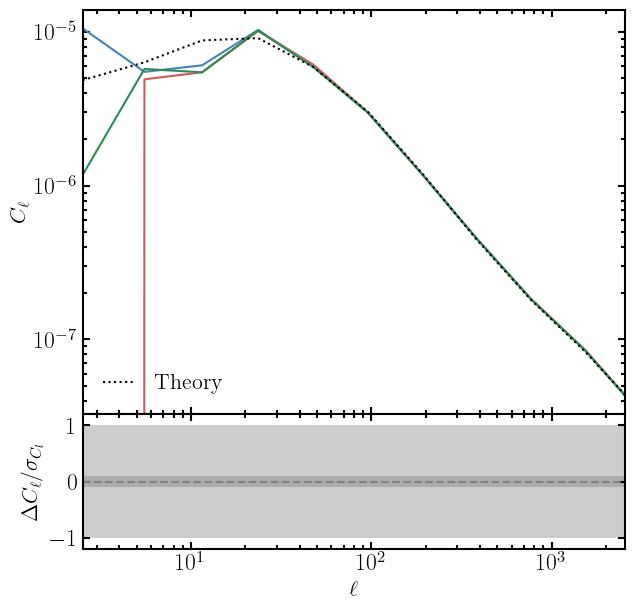

27


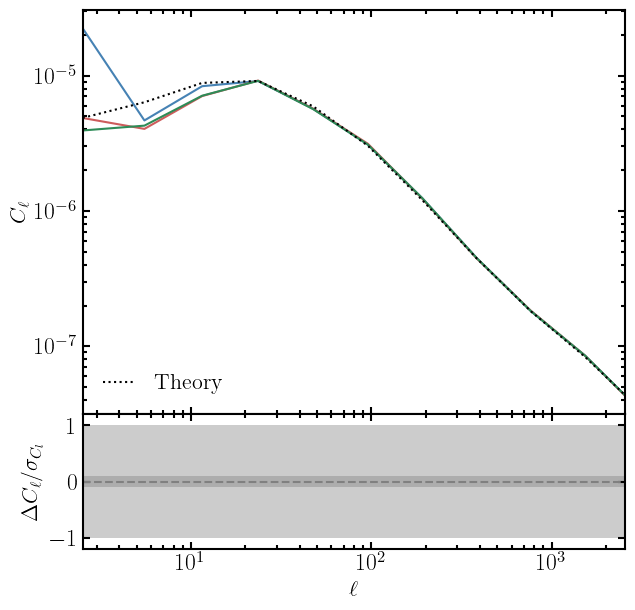

28


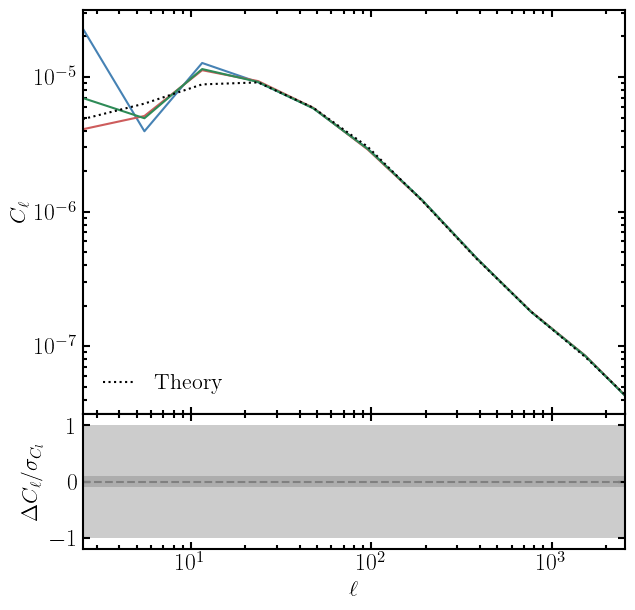

29


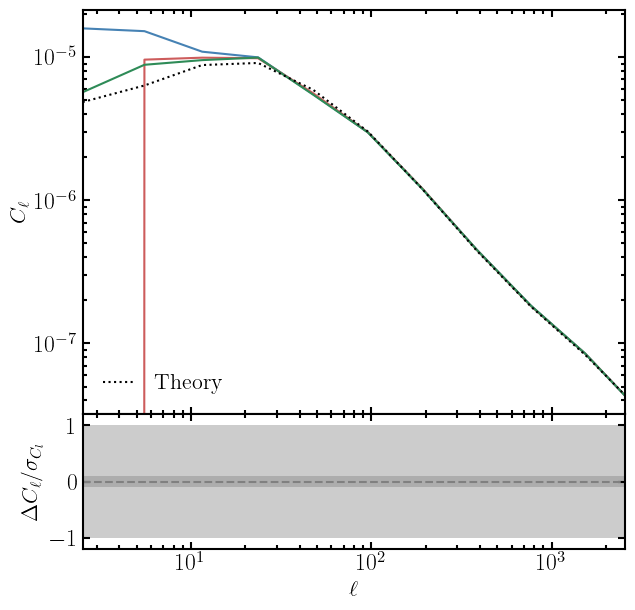

30


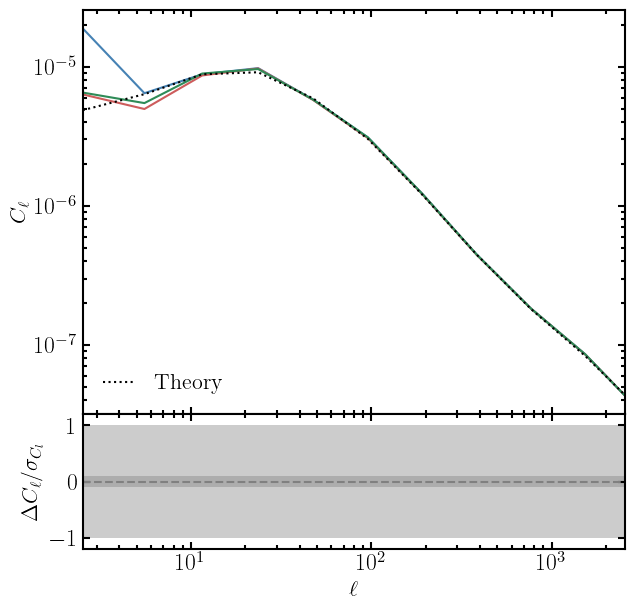

31


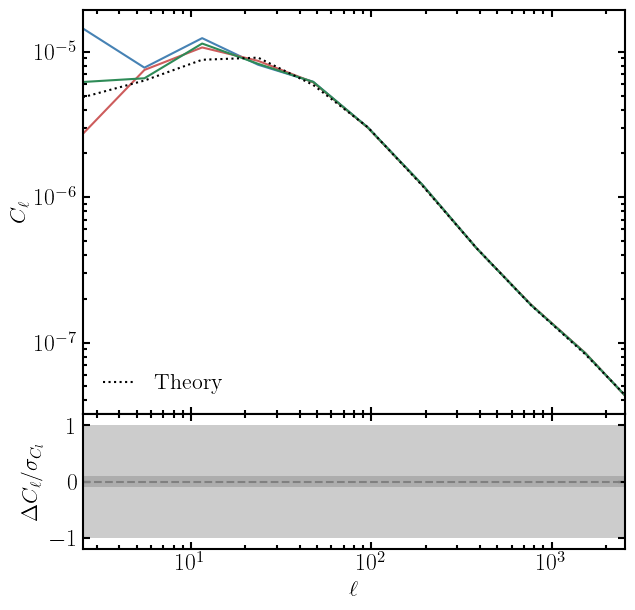

32


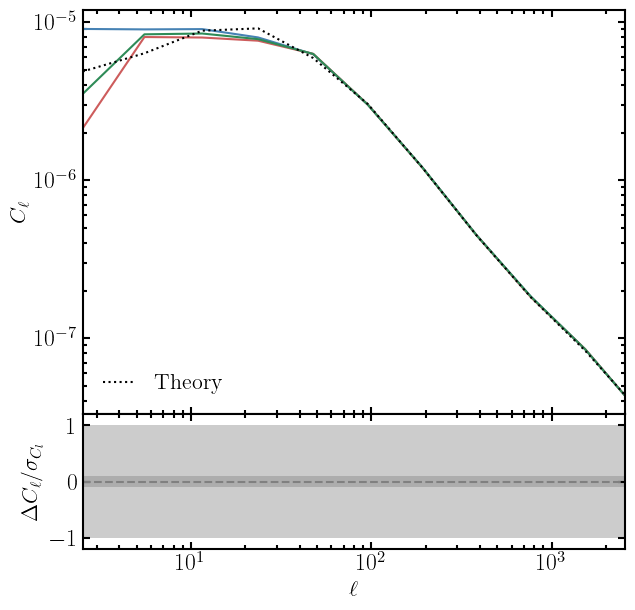

33


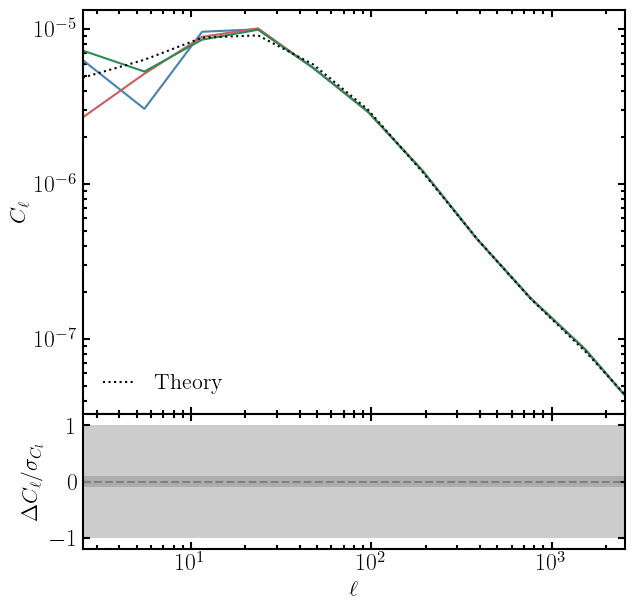

34


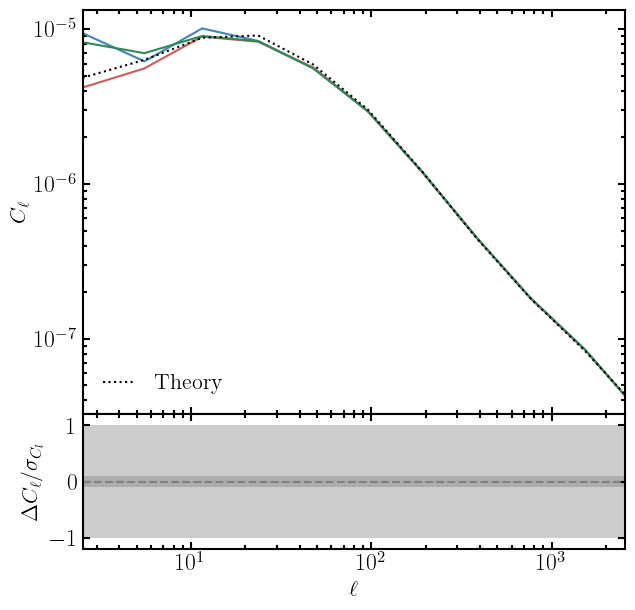

35


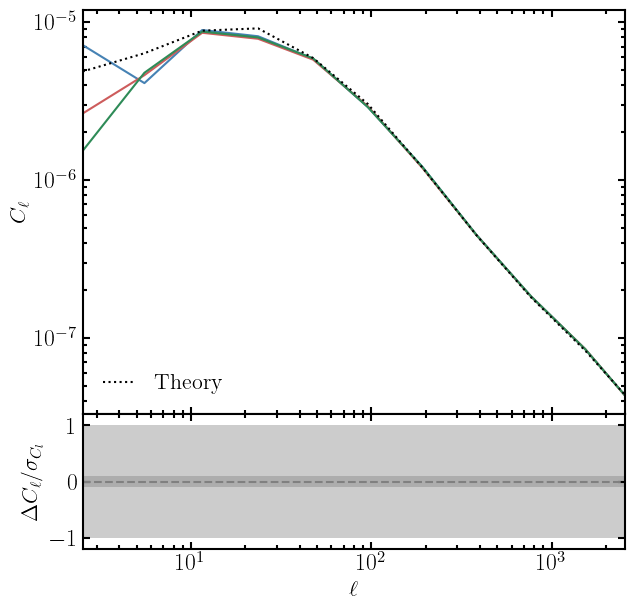

36


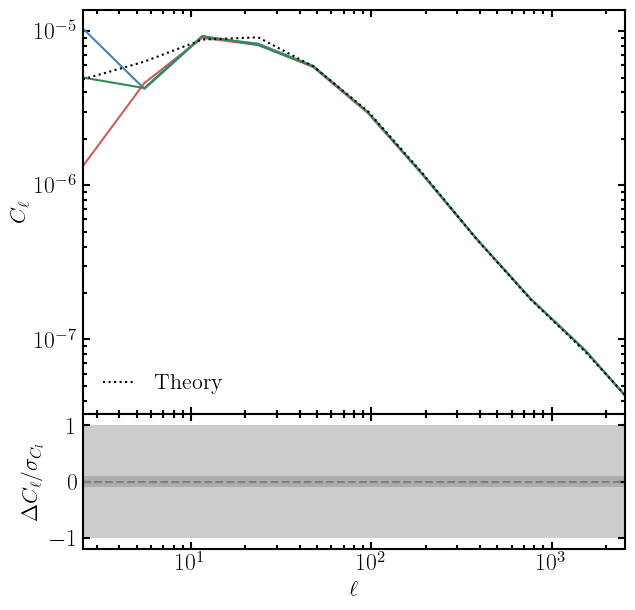

37


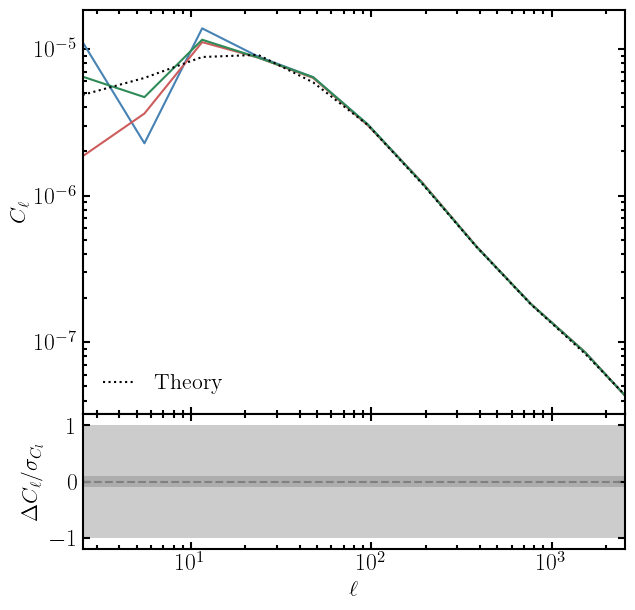

38


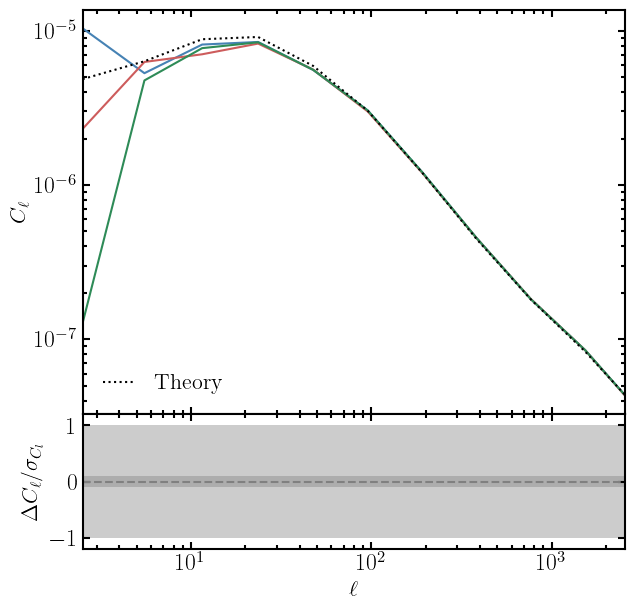

39


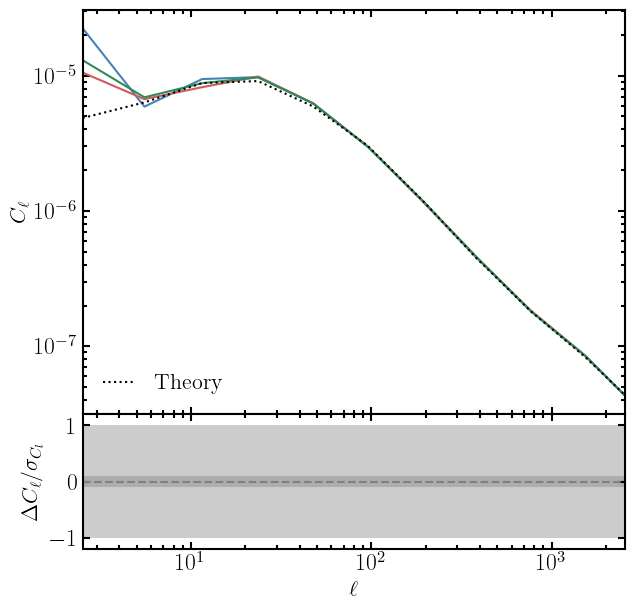

40


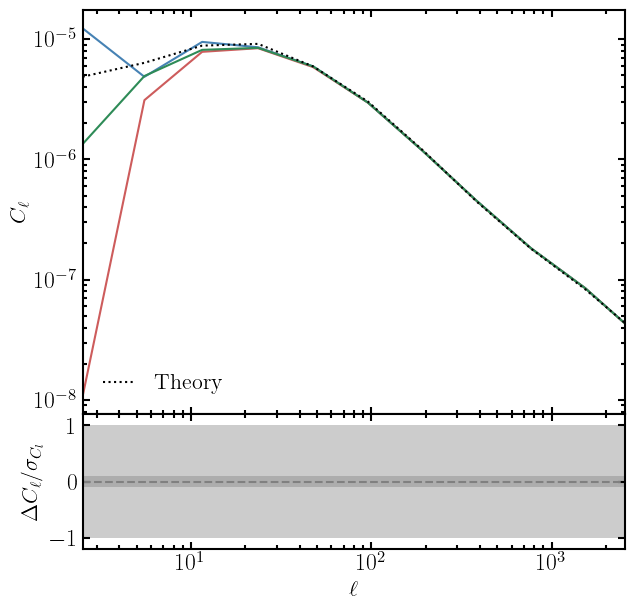

41


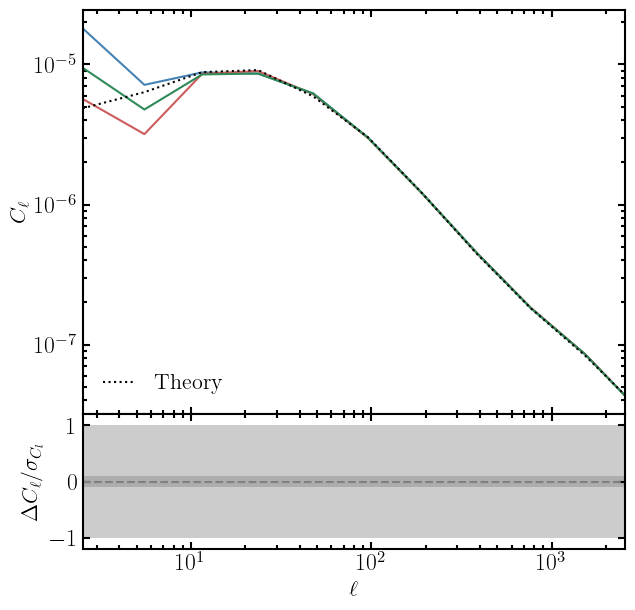

42


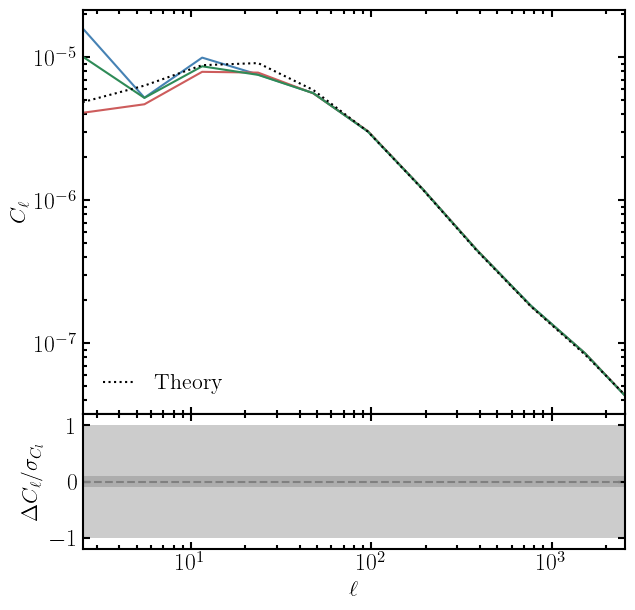

43


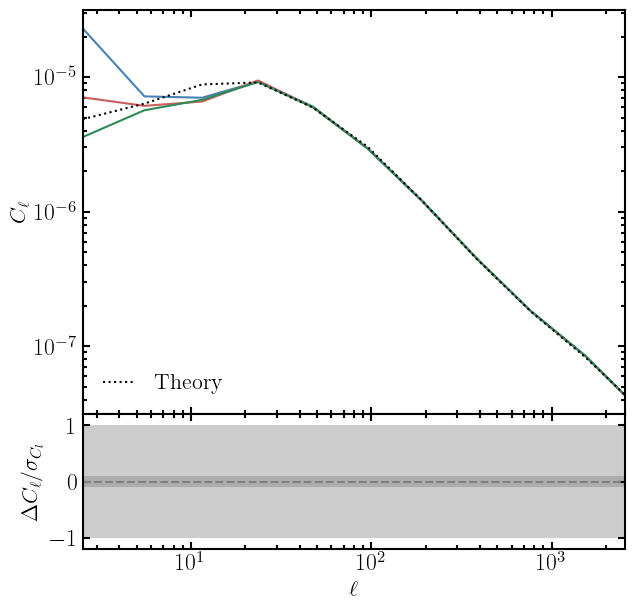

44


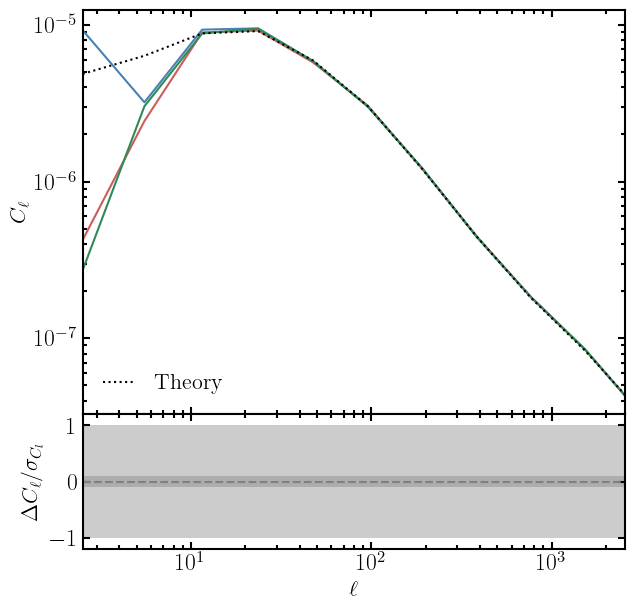

45


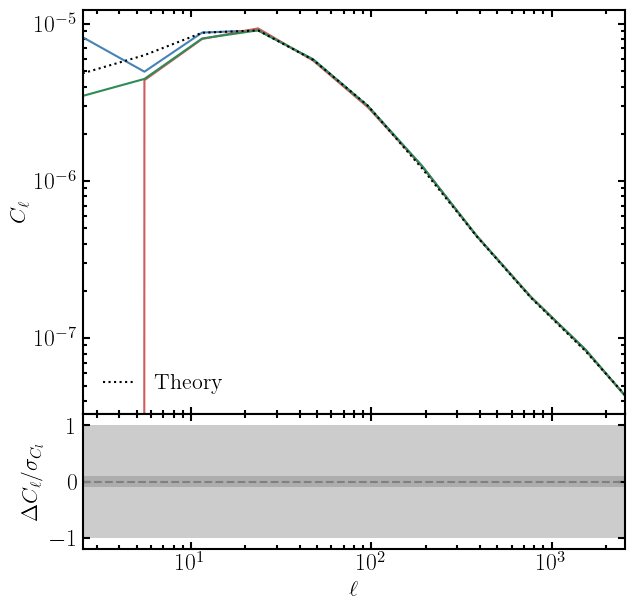

46


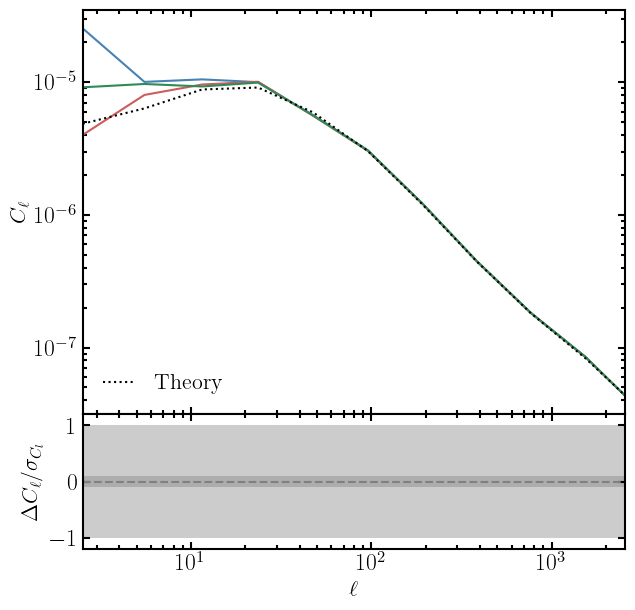

47


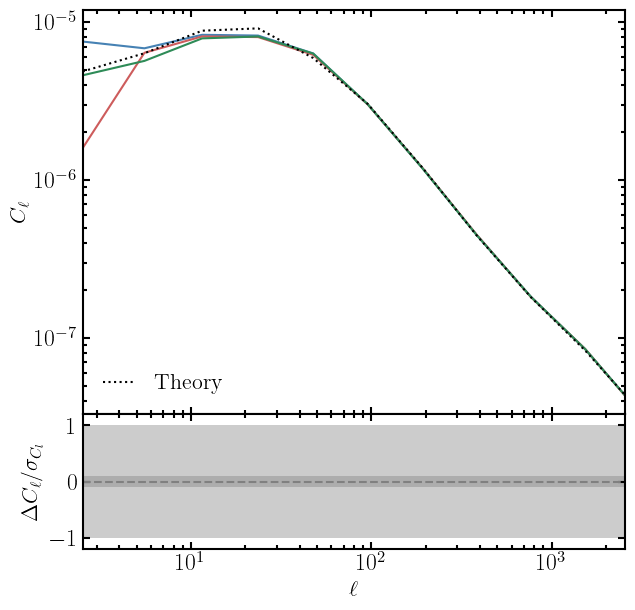

48


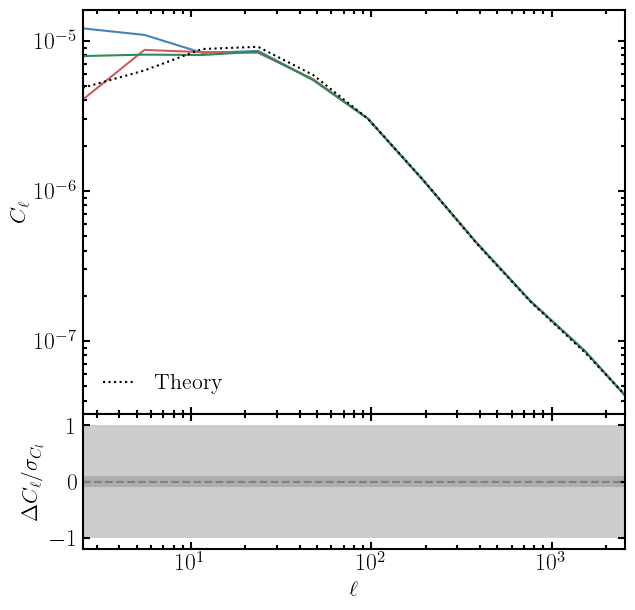

49


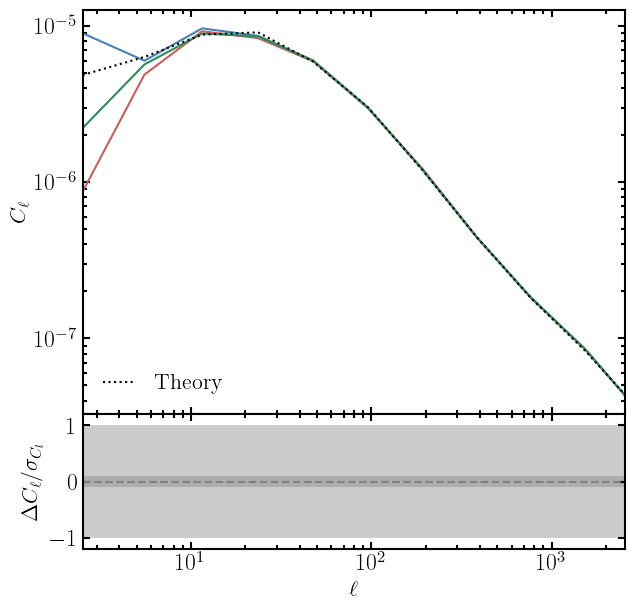

50


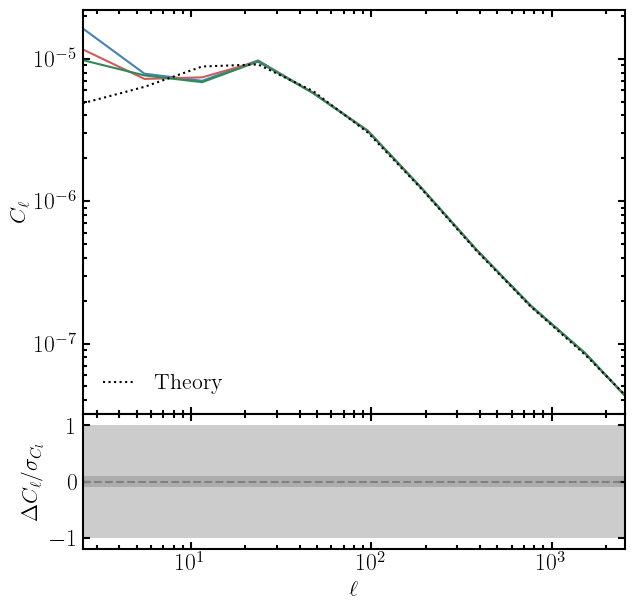

51


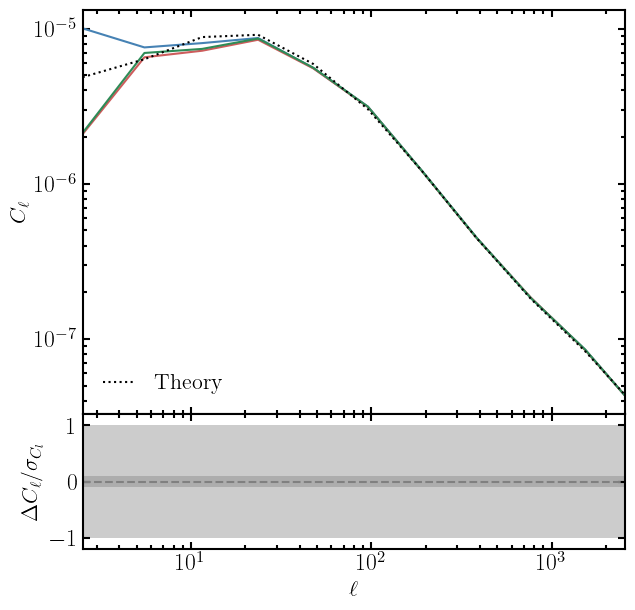

52


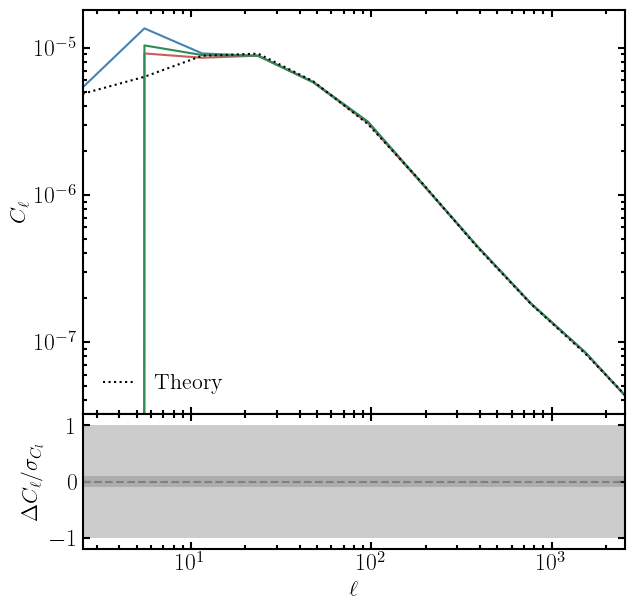

53


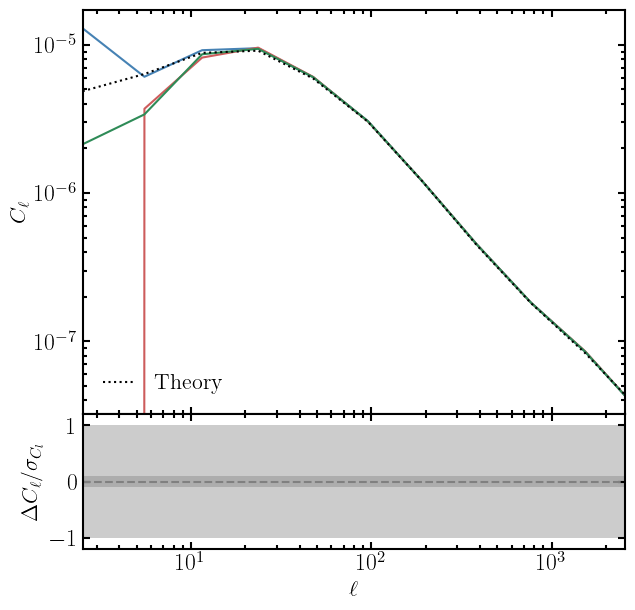

54


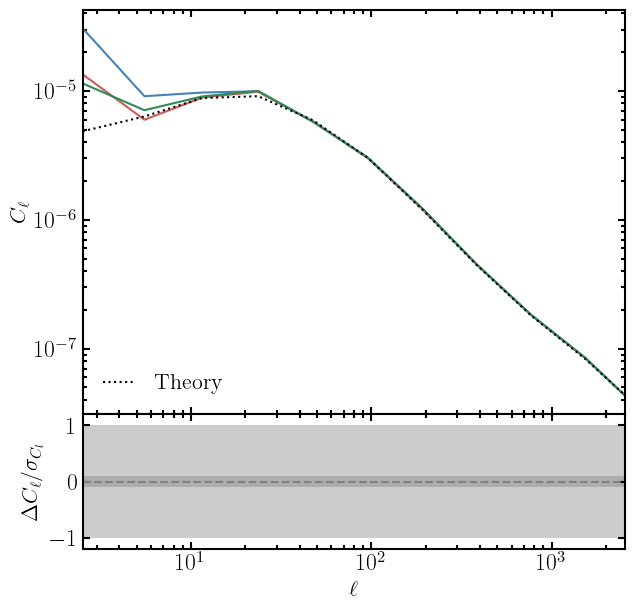

55


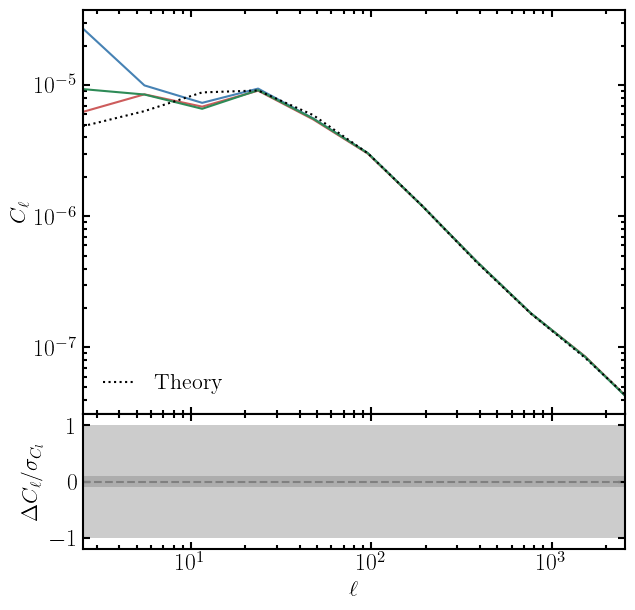

56


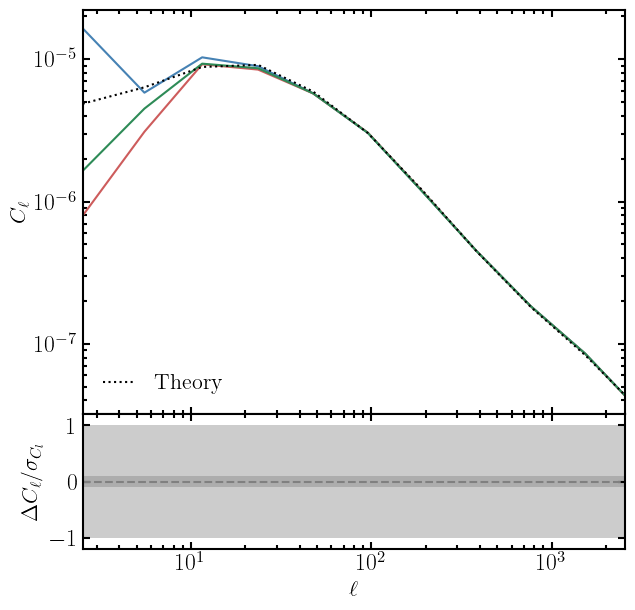

57


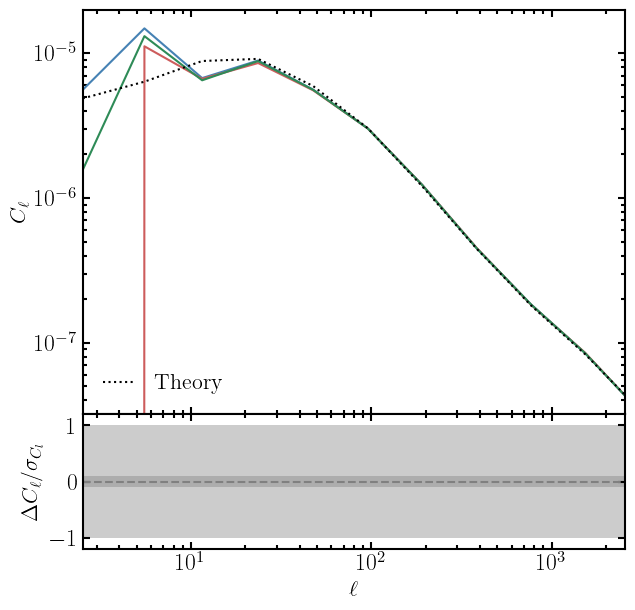

58


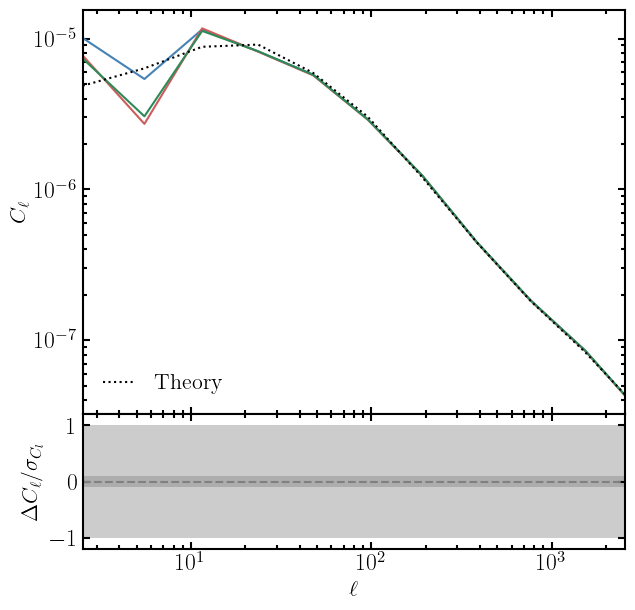

59


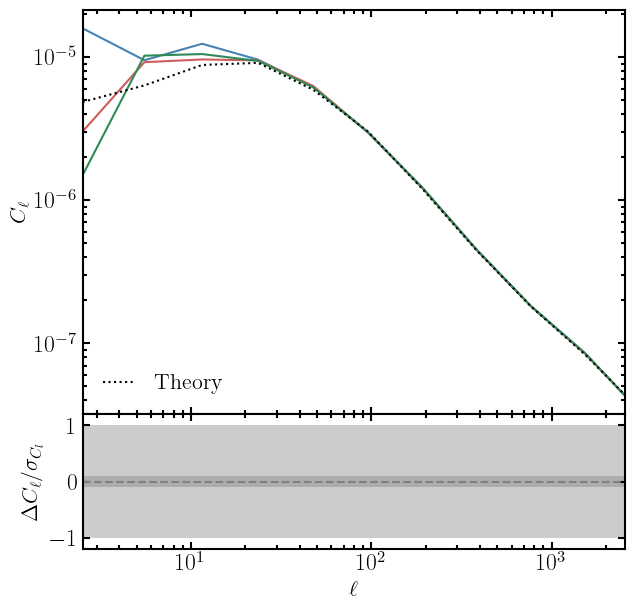

60


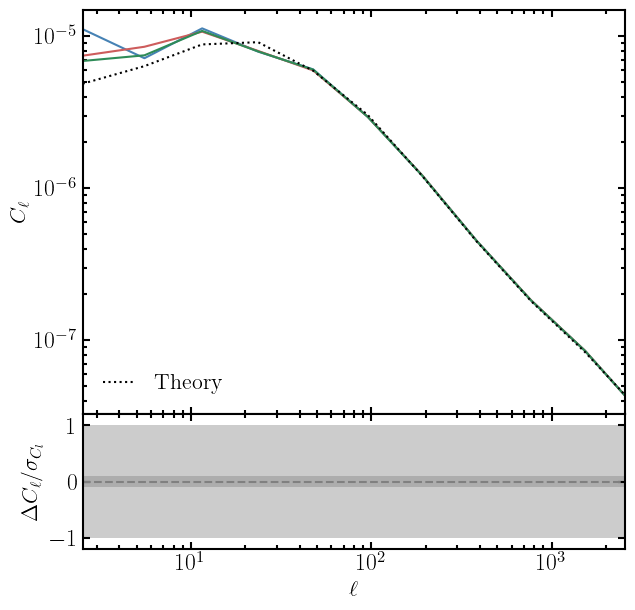

61


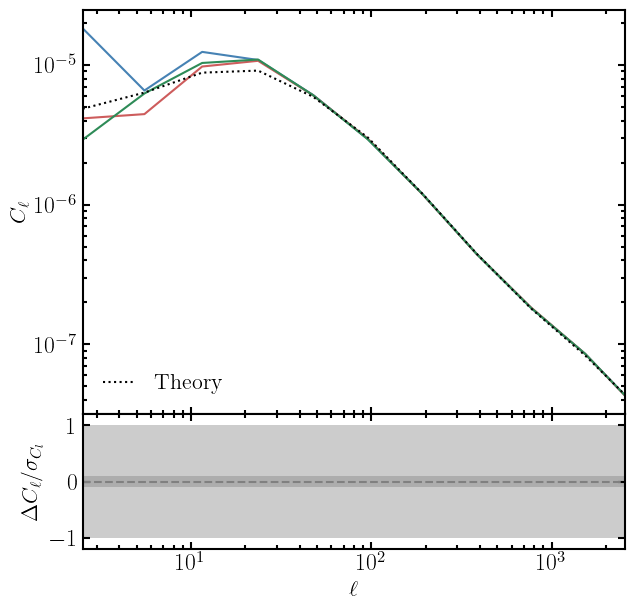

62


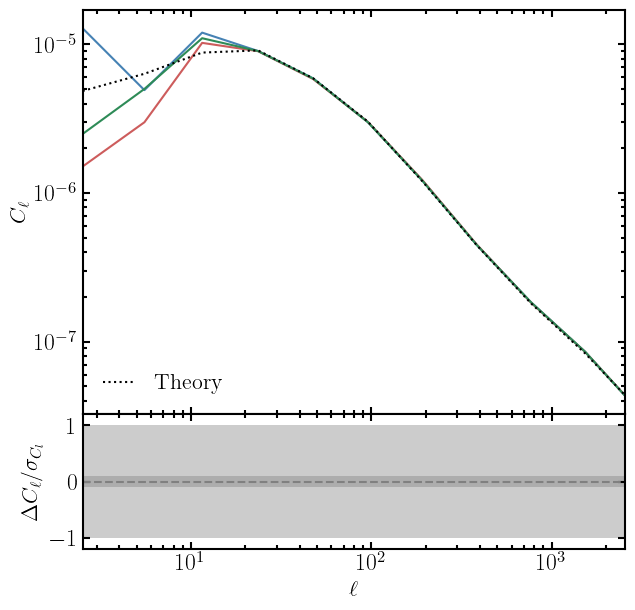

63


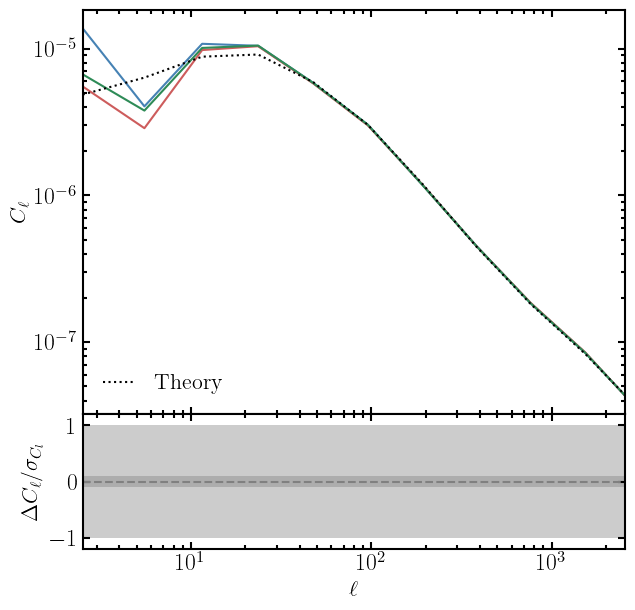

64


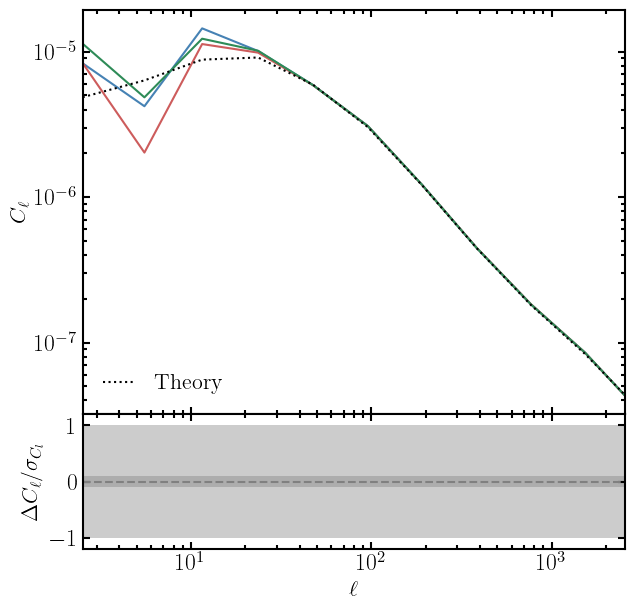

65


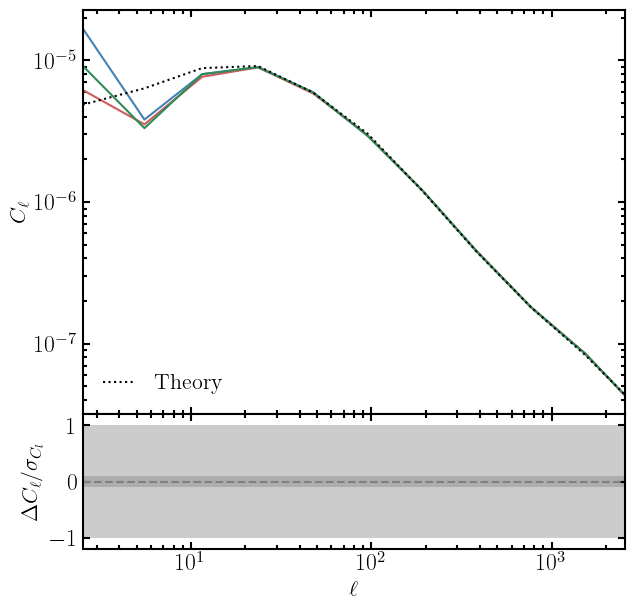

66


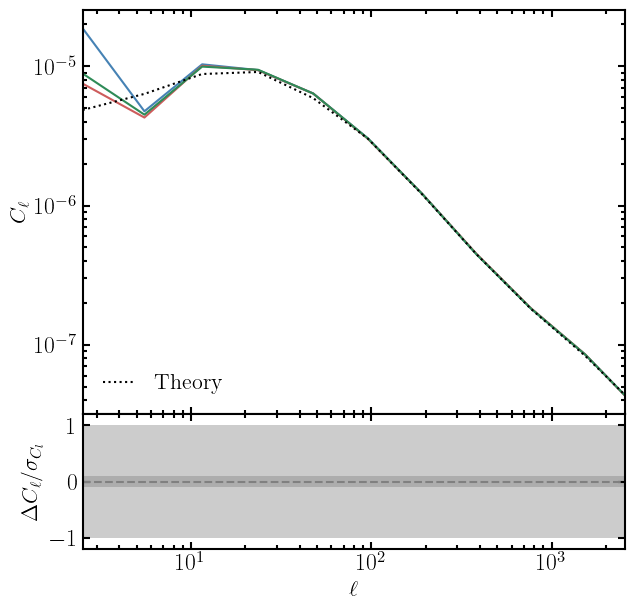

67


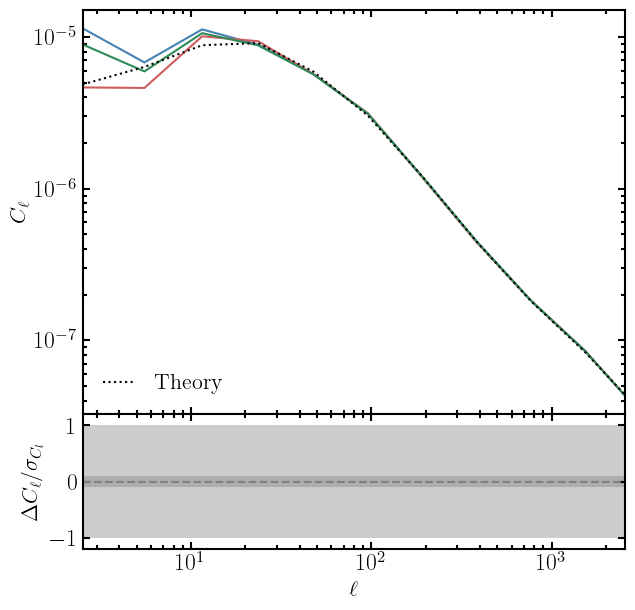

68


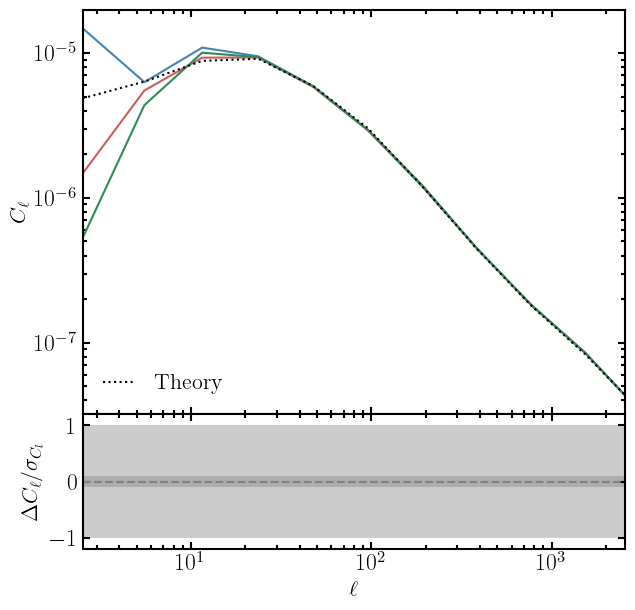

69


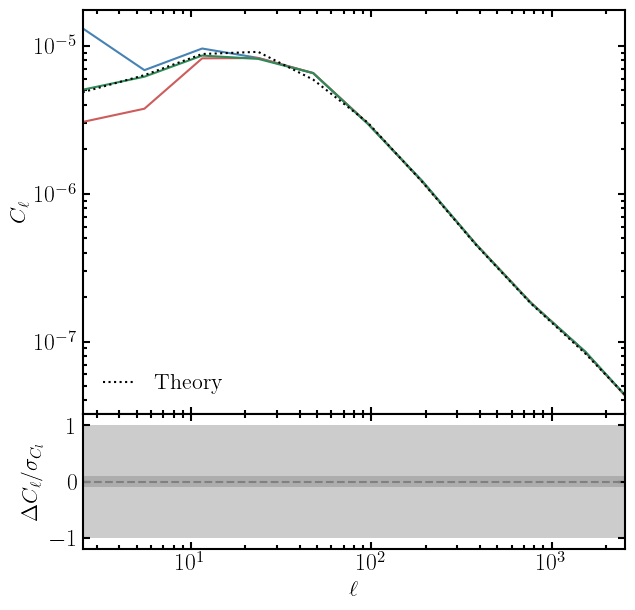

70


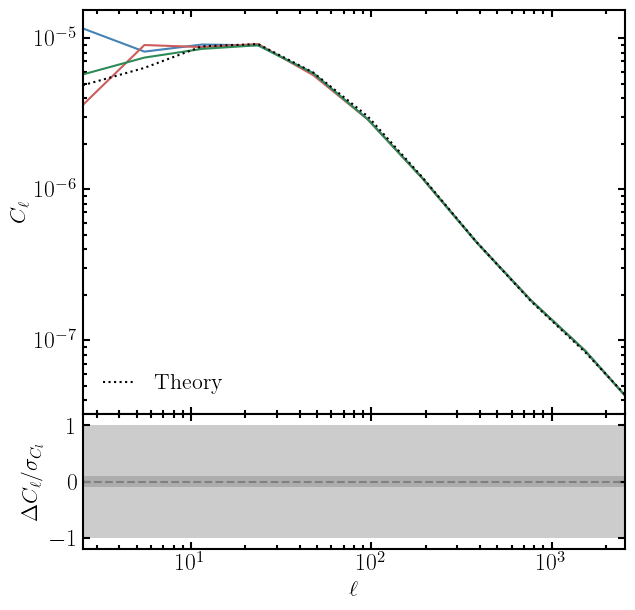

71


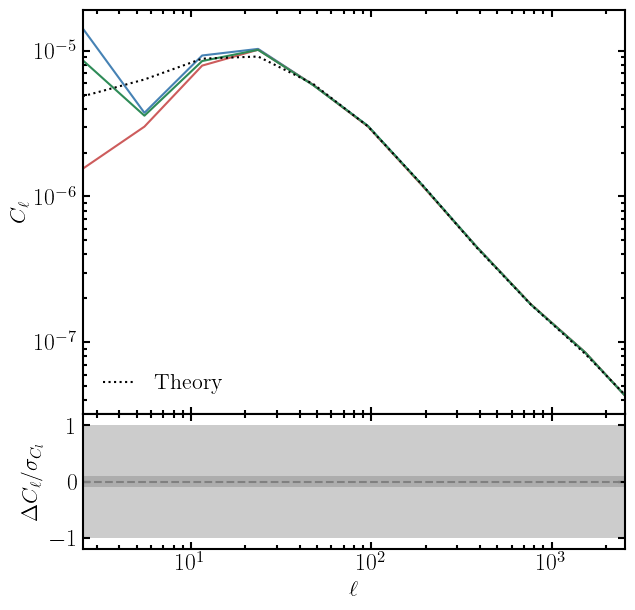

72


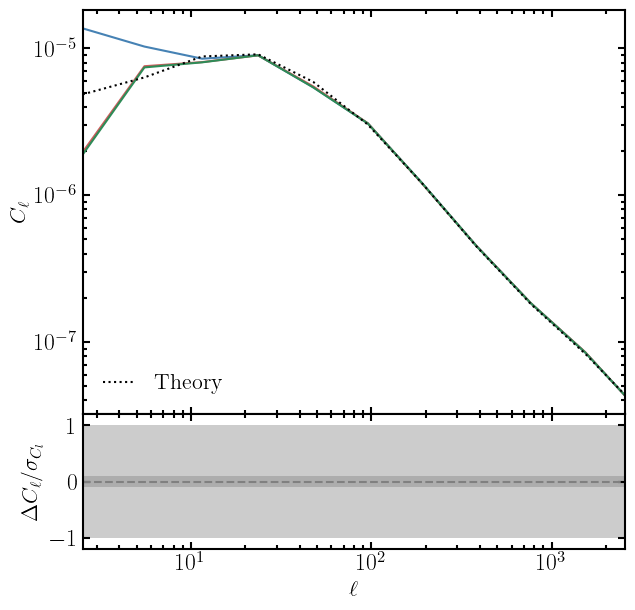

73


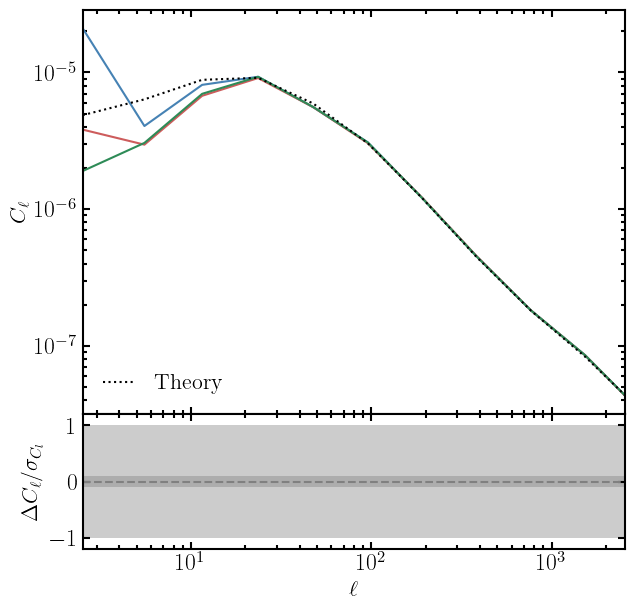

74


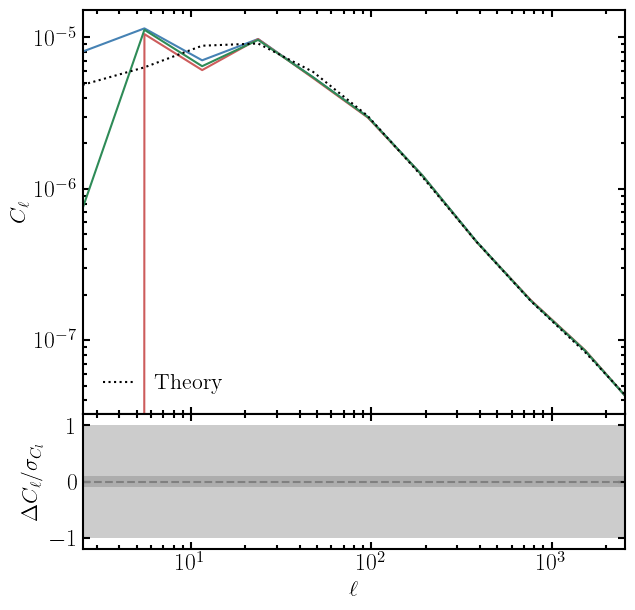

75


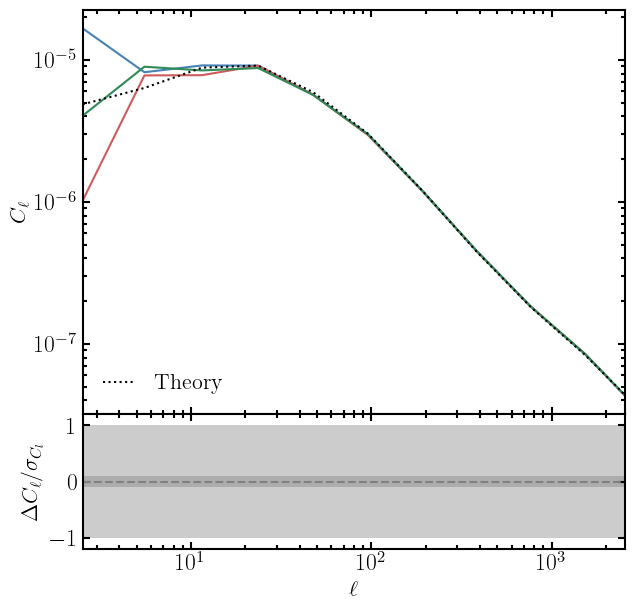

76


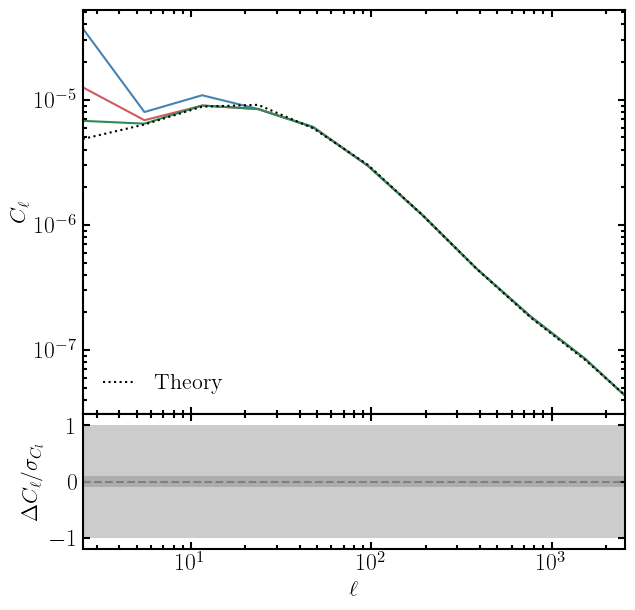

77


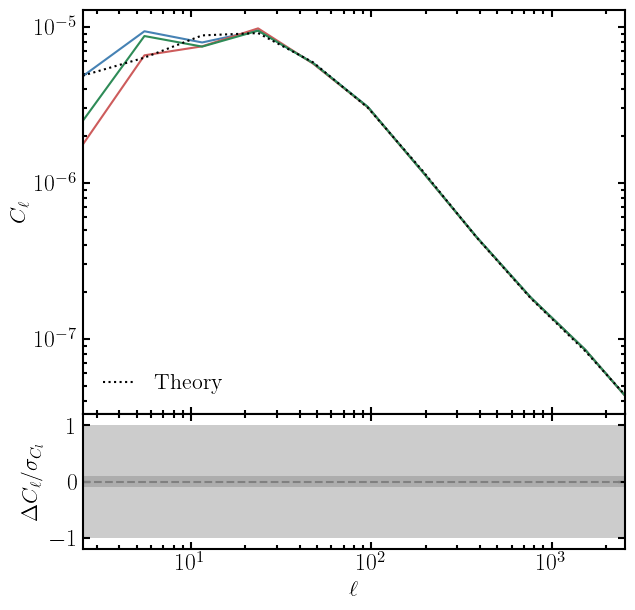

78


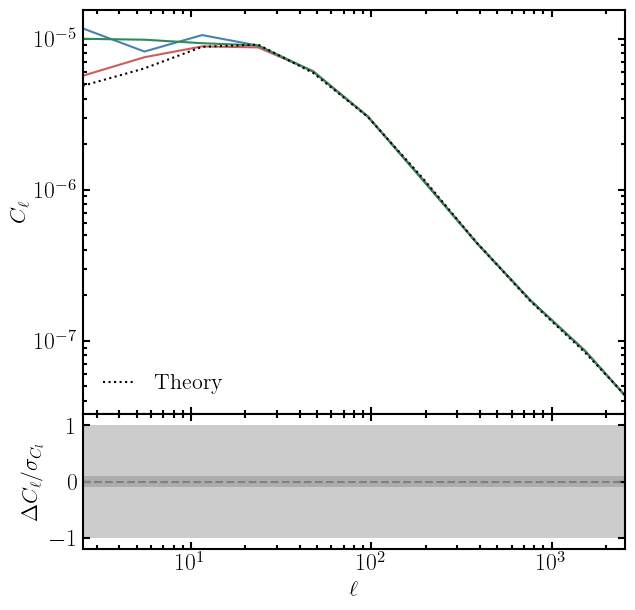

79


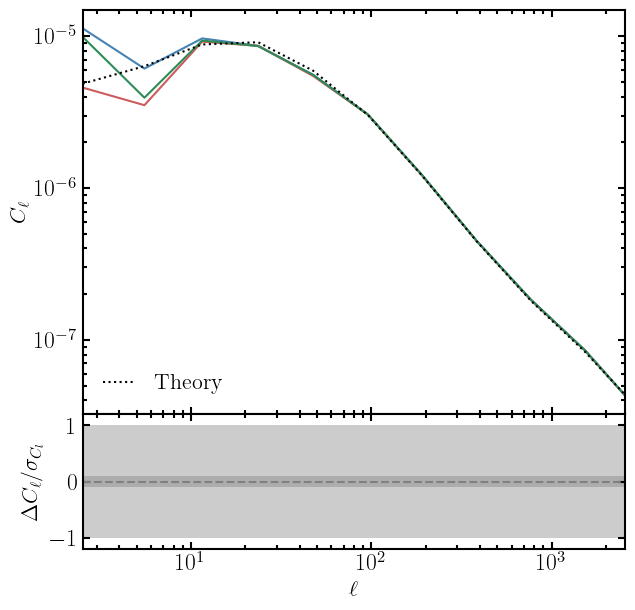

80


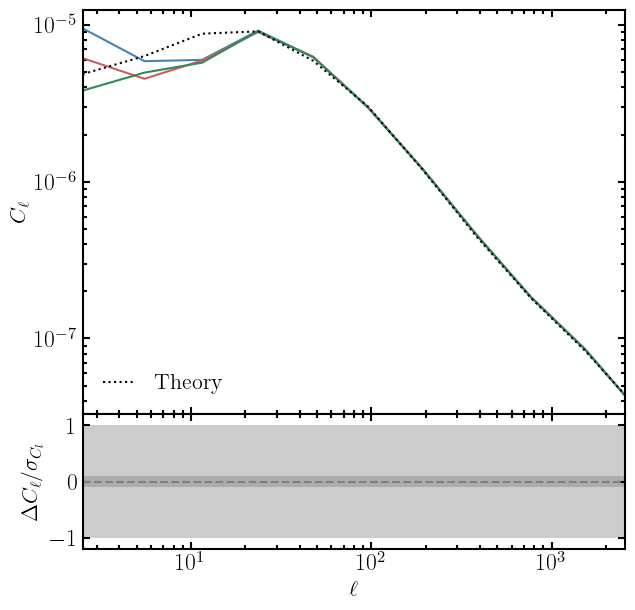

81


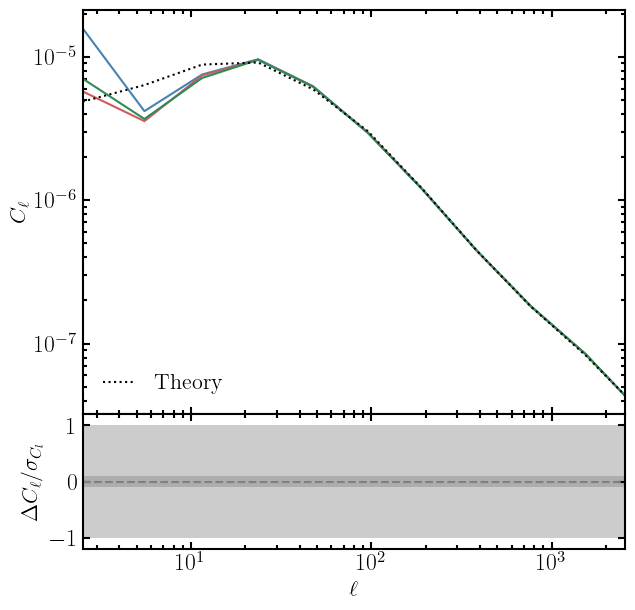

82


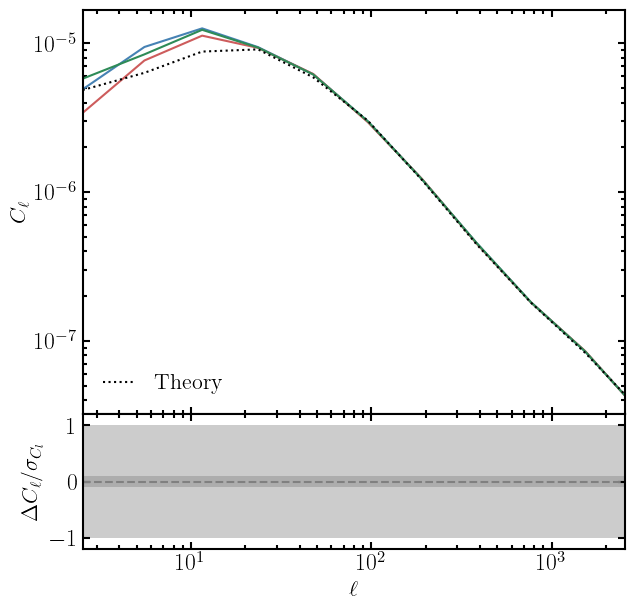

83


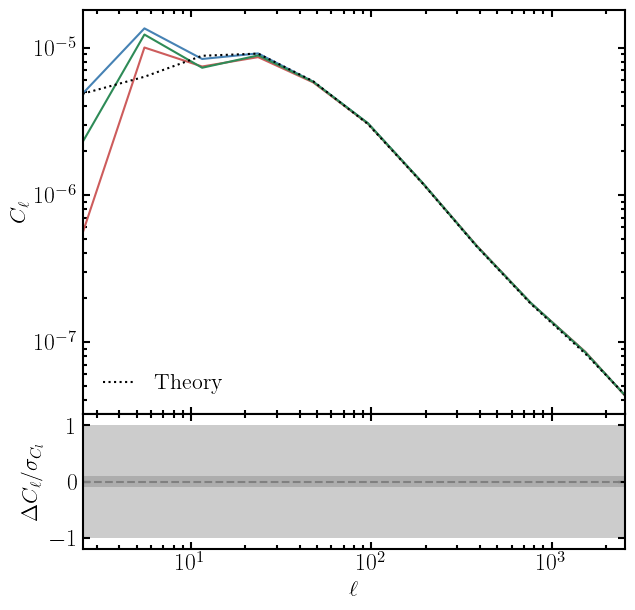

84


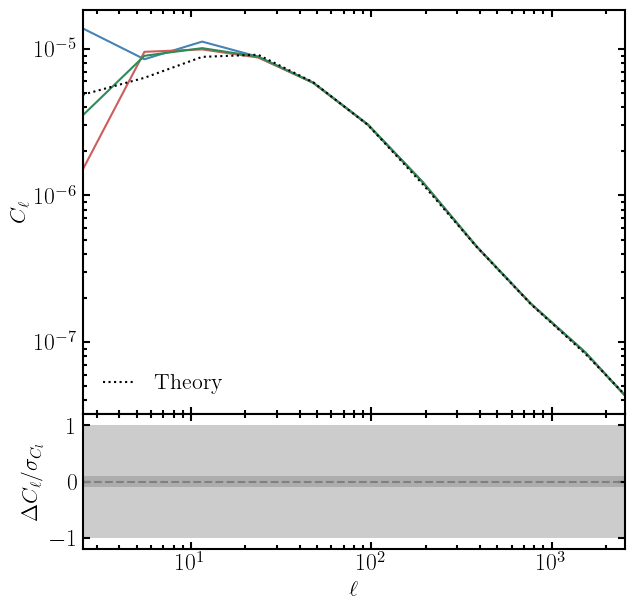

85


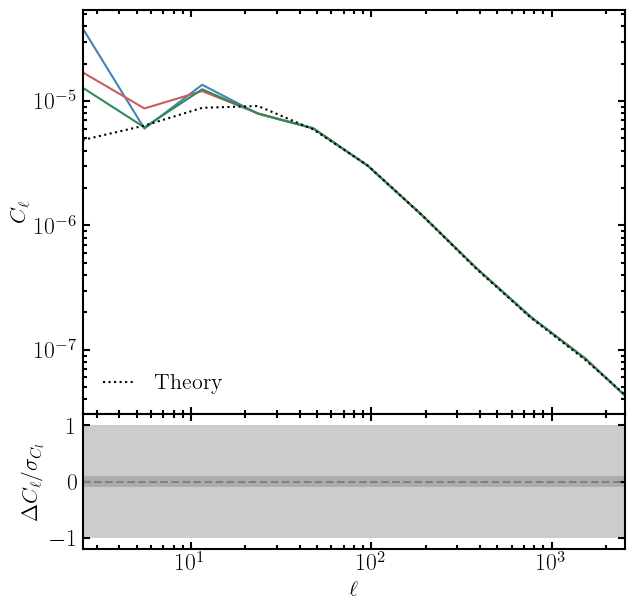

86


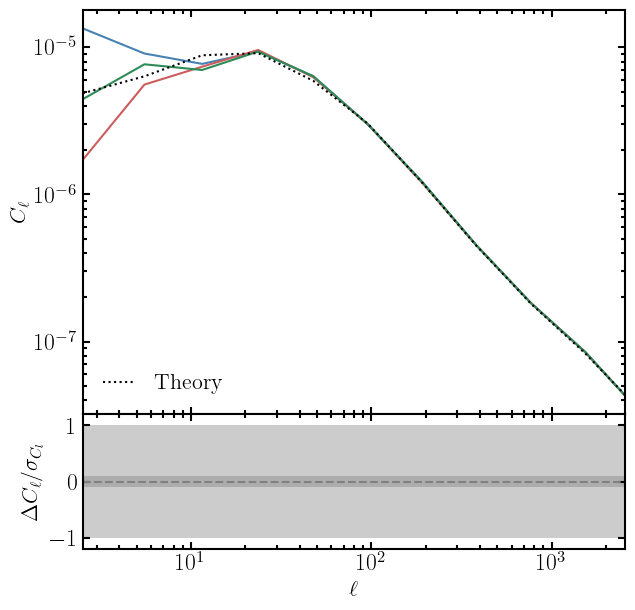

87


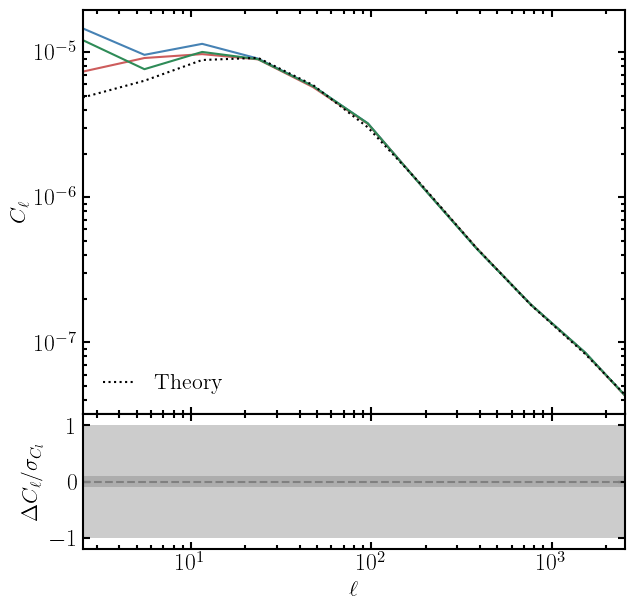

88


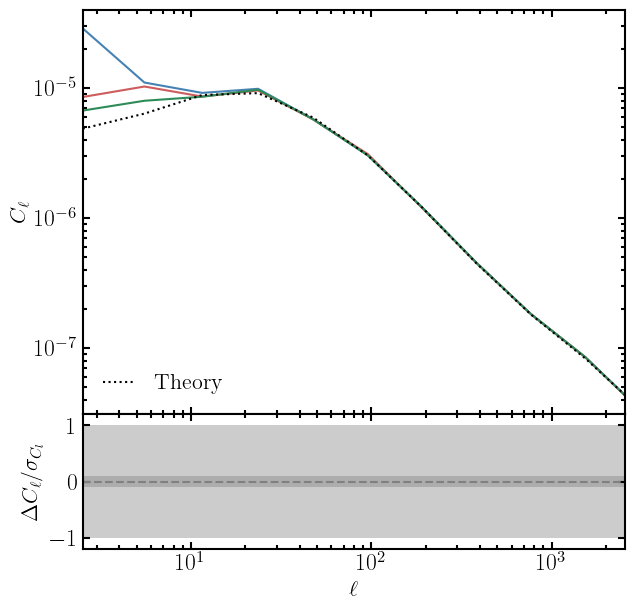

89


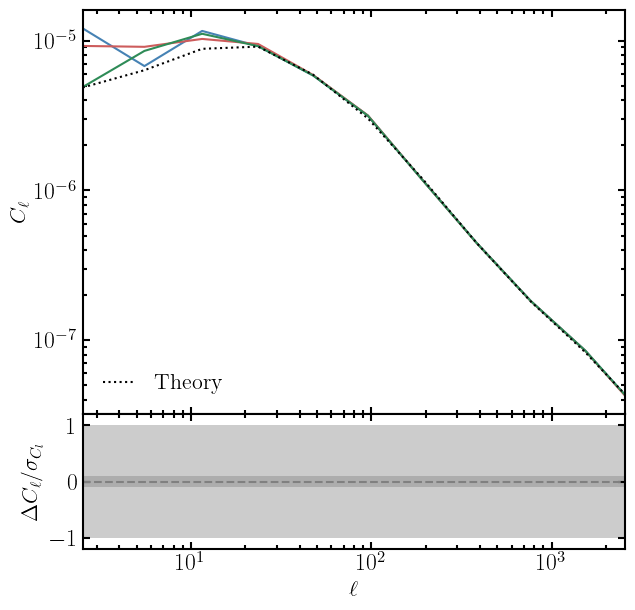

90


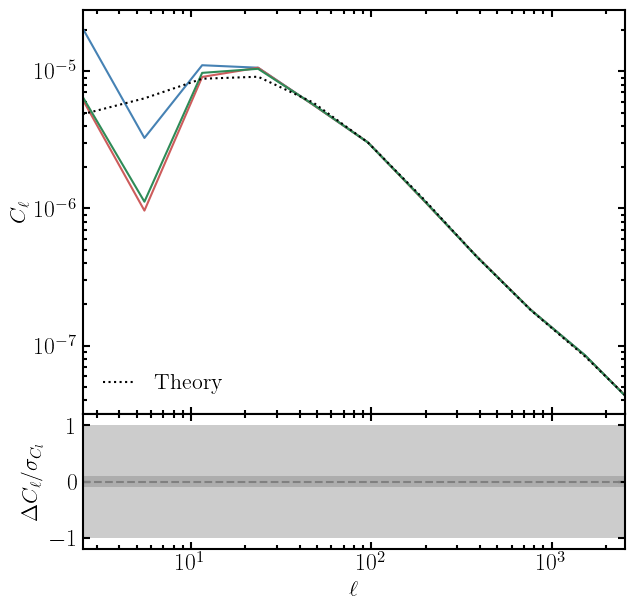

91


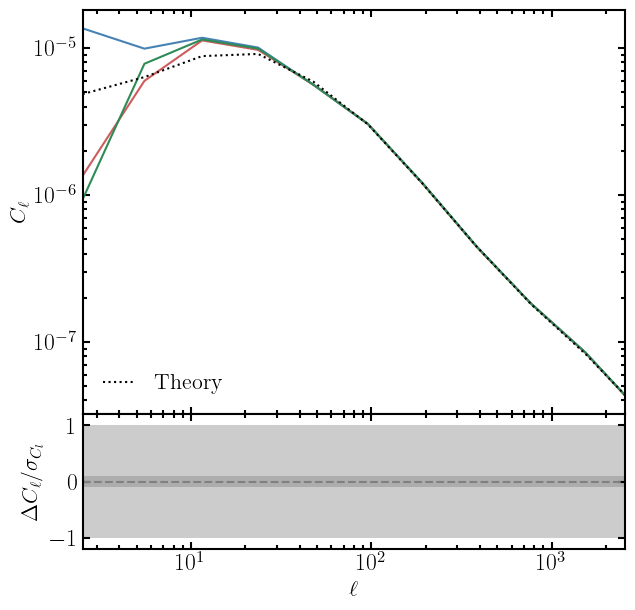

92


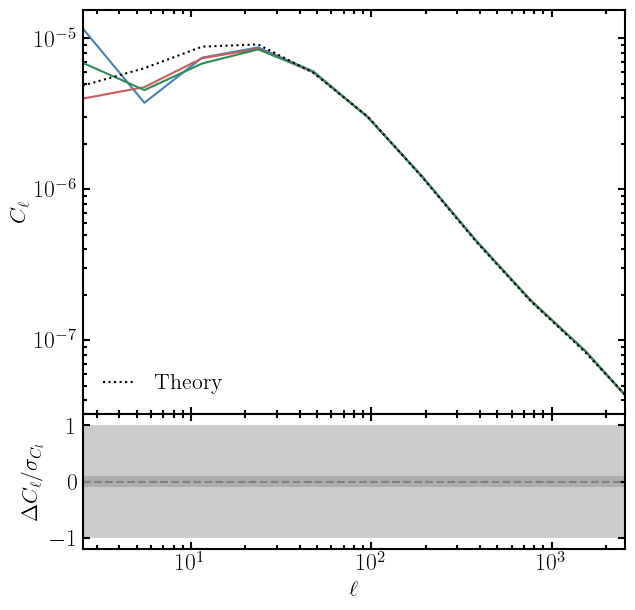

93


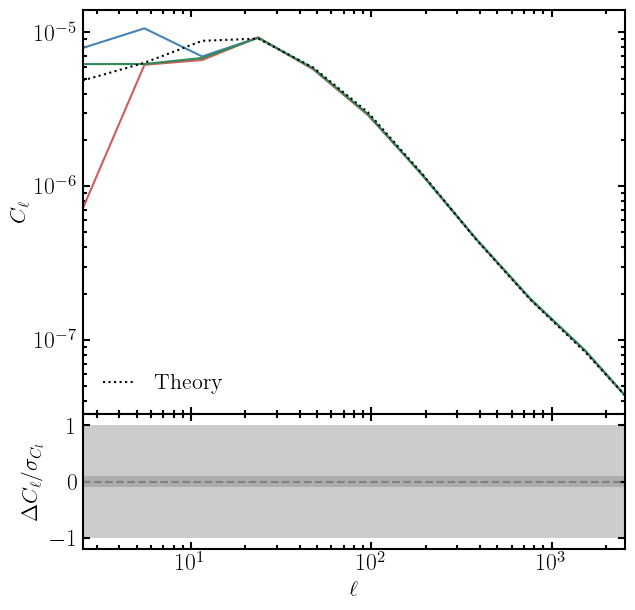

94


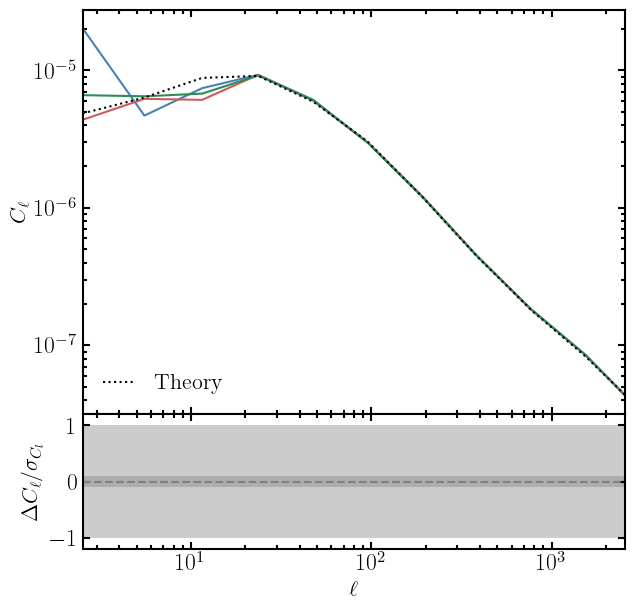

95


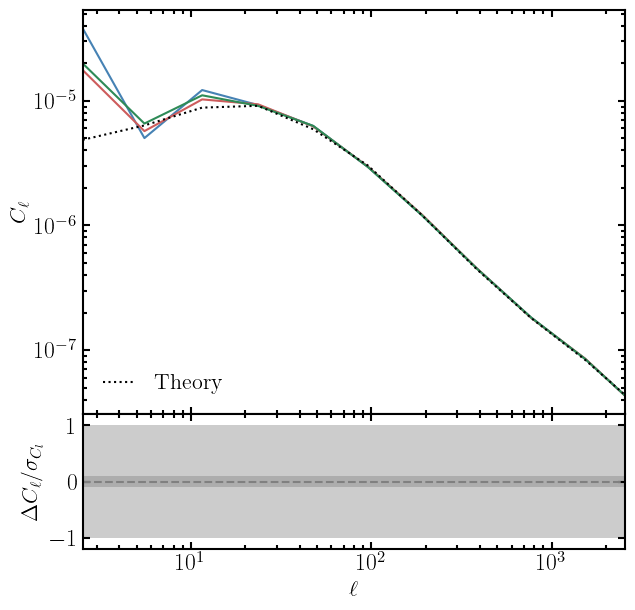

96


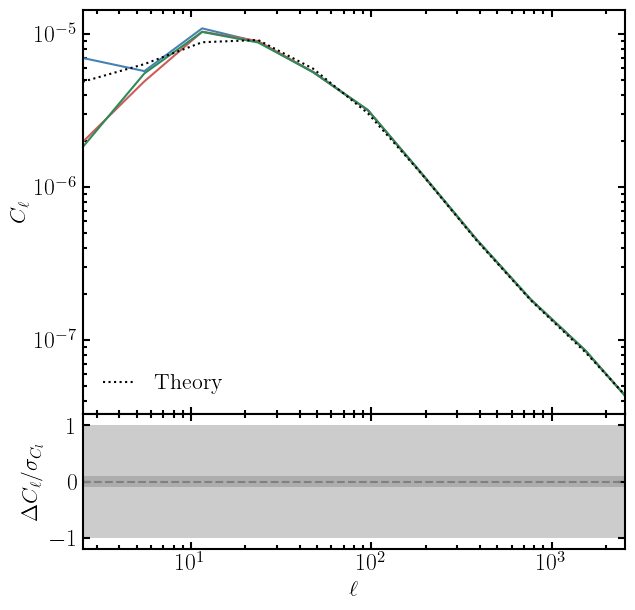

97


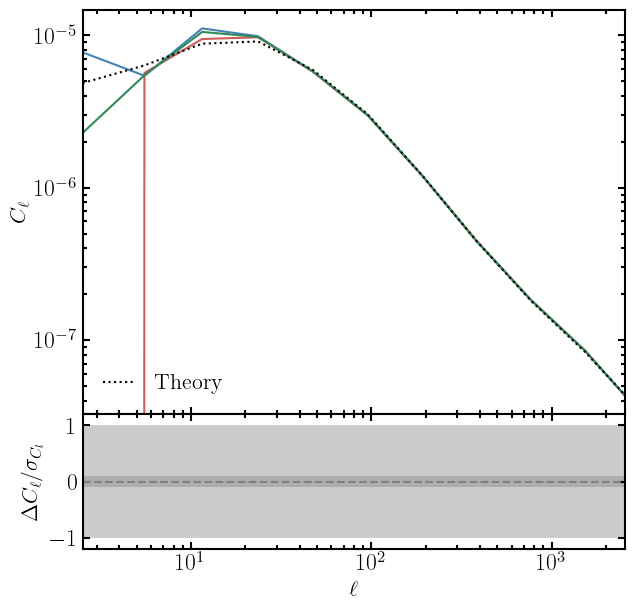

98


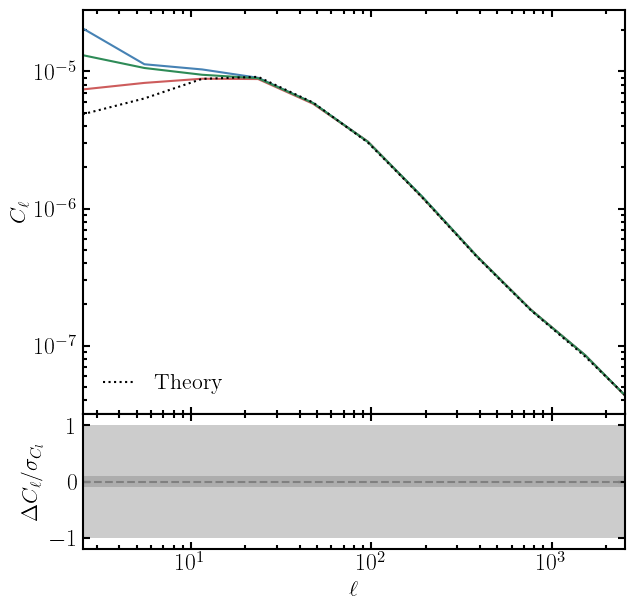

99


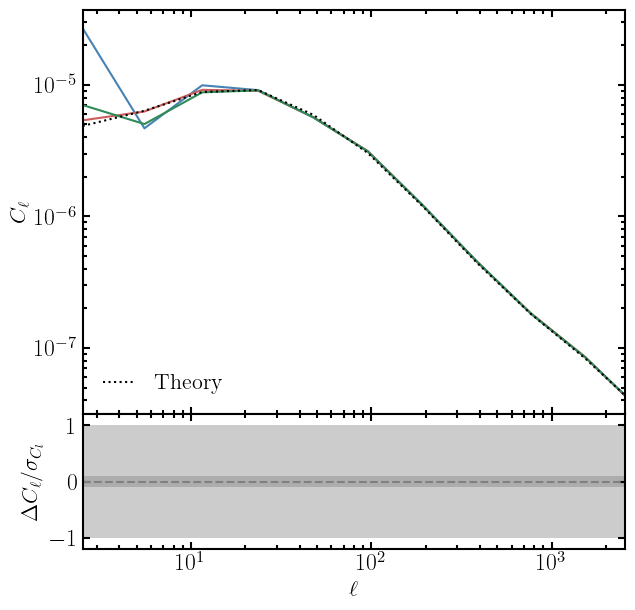

100


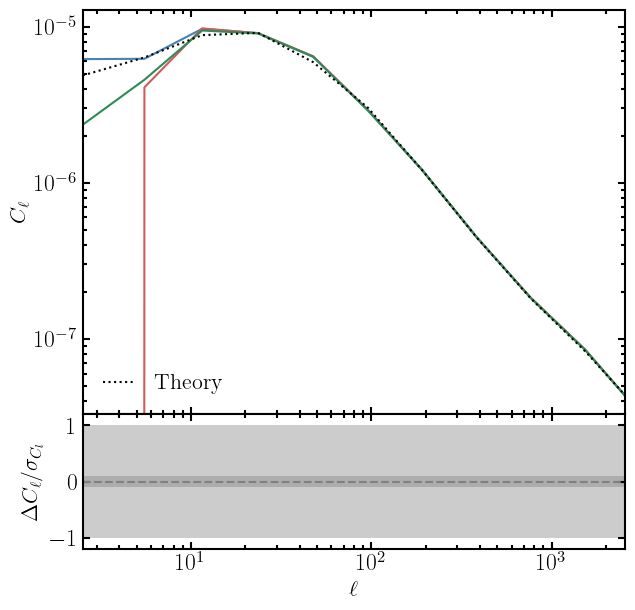

In [10]:
for i in range(Nsim):
    print(i+1)
    cls = pd.read_csv(f'{pathSALMO}ClsSALMO/Cls_{i+1}.data')

    ells = cls['ell'].to_numpy()
    cls1_mean = cls['Cl_VD_rmshotnoise'].to_numpy() 
    cls0_mean = cls['Cl_NoVD_rmshotnoise'].to_numpy()
    clsD_mean = cls['Cl_Deprojected_rmshotnoise'].to_numpy()
    clsrew_mean = cls['Cl_Reweighted_rmshotnoise'].to_numpy()
    #cls1_unc = cls['Cl_VD_rmshotnoise unc'].to_numpy()
    #cls0_unc = cls['Cl_NoVD_rmshotnoise unc'].to_numpy()
    #clsD_unc = cls['Cl_Deprojected_rmshotnoise unc'].to_numpy()
    #clsrew_unc = cls['Cl_Reweighted_rmshotnoise unc'].to_numpy()

    fig = plt.figure(figsize=(7,7))
    fig_grid = fig.add_gridspec(1,1)

    plots_grid = fig_grid[0,0].subgridspec(2,1,hspace=0, height_ratios=[3,1])
    axs = plots_grid.subplots()

    axs[0].plot(ells, cls1_mean, color='steelblue')
    #axs[0].fill_between(ells, cls1_mean- cls1_unc, cls1_mean+ cls1_unc, color='steelblue', alpha=0.4, label='With VD')
    axs[0].plot(ells, cls0_mean, color='indianred')
    #axs[0].fill_between(ells, cls0_mean- cls0_unc, cls0_mean+ cls0_unc, color='indianred', alpha=0.4, label='Without VD')
    axs[0].plot(ells, clsD_mean, color='seagreen')
    #axs[0].fill_between(ells, clsD_mean- clsD_unc, clsD_mean+ clsD_unc, color='seagreen', alpha=0.4, label='Deprojected')
    #axs[0].plot(ells, clsrew_mean, color='orange')
    #axs[0].fill_between(ells, clsrew_mean- clsrew_unc, clsrew_mean+ clsrew_unc, color='orange', alpha=0.4, label='Reweighted')
    axs[0].plot(ells, cls_theo, color='black', linestyle=':', label='Theory')
    #axs[0].fill_between(ells, cls_theo- cls0_unc*np.sqrt(Nsim), cls_theo+ cls0_unc*np.sqrt(Nsim), color='grey', alpha=0.4, zorder=0)
    #axs[0].plot(np.load('data_DELS/ls.npy')[:-6:10], np.load('data_DELS/cl.npy')/1.48**2, color='black', linestyle=':', label='DECALS')
    #axs[0].plot(ells, clsx[0], color='orange', linestyle=':')

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_ylabel(f'$C_\\ell$', fontsize=16)
    axs[0].legend(loc='lower left', frameon=False)
    axs[0].set_xlim(ells[0],ells[-1])
    #axs[0].set_ylim(1e-8, 3e-3)

    #dev1 = (cls0_mean - cls1_mean) / cls0_unc / np.sqrt(Nsim)
    #devD = (cls0_mean - clsD_mean) / cls0_unc/ np.sqrt(Nsim)
    #dev_rew = (cls0_mean - clsrew_mean) / cls0_unc/ np.sqrt(Nsim)
    #axs[1].plot(ells, dev1, color='steelblue')
    #axs[1].plot(ells, devD, color='seagreen')
    #axs[1].plot(ells, dev_rew, color='orange')

    axs[1].axhline(0,ls='--', color='grey')
    axs[1].set_ylabel('$\\Delta C_\\ell /\\sigma_{C_l}$', fontsize=16)
    axs[1].fill_between(y1=-.1, y2=.1, x=ells, alpha=0.4, color='grey', edgecolor=None)
    axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.4, color='grey', edgecolor=None)
    axs[1].set_ylim(-1.2,1.2)
    axs[1].set_xlabel(f'$\\ell$', fontsize=16)
    axs[1].set_xlim(ells[0], ells[-1])
    axs[1].set_xscale('log')
    if savefigs:
        plt.savefig(f'{pathFIGS_SALMO}Cls_SALMO.png')
    plt.show()

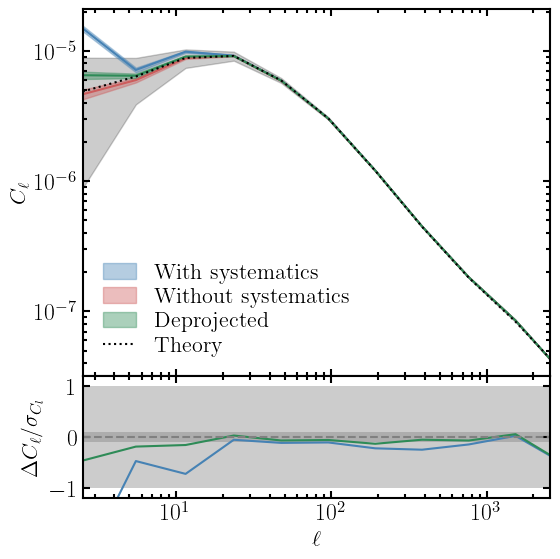

In [11]:
cls = pd.read_csv(f'{pathSALMO}ClsSALMO/mean_Cls.data')

ells = cls['ell'].to_numpy()
cls1_mean = cls['Cl_VD_rmshotnoise'].to_numpy() 
cls0_mean = cls['Cl_NoVD_rmshotnoise'].to_numpy()
clsD_mean = cls['Cl_Deprojected_rmshotnoise'].to_numpy()
clsrew_mean = cls['Cl_Reweighted_rmshotnoise'].to_numpy()
cls1_unc = cls['Cl_VD_rmshotnoise unc'].to_numpy()
cls0_unc = cls['Cl_NoVD_rmshotnoise unc'].to_numpy()
clsD_unc = cls['Cl_Deprojected_rmshotnoise unc'].to_numpy()
clsrew_unc = cls['Cl_Reweighted_rmshotnoise unc'].to_numpy()

fig = plt.figure(figsize=(6,6))
fig_grid = fig.add_gridspec(1,1)

plots_grid = fig_grid[0,0].subgridspec(2,1,hspace=0, height_ratios=[3,1])
axs = plots_grid.subplots()

axs[0].plot(ells, cls1_mean, color='steelblue')
axs[0].fill_between(ells, cls1_mean- cls1_unc, cls1_mean+ cls1_unc, color='steelblue', alpha=0.4, label='With systematics')
axs[0].plot(ells, cls0_mean, color='indianred')
axs[0].fill_between(ells, cls0_mean- cls0_unc, cls0_mean+ cls0_unc, color='indianred', alpha=0.4, label='Without systematics')
axs[0].plot(ells, clsD_mean, color='seagreen')
axs[0].fill_between(ells, clsD_mean- clsD_unc, clsD_mean+ clsD_unc, color='seagreen', alpha=0.4, label='Deprojected')
#axs[0].plot(ells, clsrew_mean, color='orange')
#axs[0].fill_between(ells, clsrew_mean- clsrew_unc, clsrew_mean+ clsrew_unc, color='orange', alpha=0.4, label='Reweighted')
axs[0].plot(ells, cls_theo, color='black', linestyle=':', label='Theory')
axs[0].fill_between(ells, cls_theo- cls0_unc*np.sqrt(Nsim), cls_theo+ cls0_unc*np.sqrt(Nsim), color='black', alpha=0.2, zorder=0)
#axs[0].plot(np.load('data_DELS/ls.npy')[:-6:10], np.load('data_DELS/cl.npy')/1.48**2, color='black', linestyle=':', label='DECALS')
#axs[0].plot(ells, clsx[0], color='orange', linestyle=':')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(f'$C_\\ell$', fontsize=16)
axs[0].legend(loc='lower left', frameon=False)
axs[0].set_xlim(ells[0],ells[-1])
#axs[0].set_ylim(1e-8, 3e-3)

dev1 = (cls0_mean - cls1_mean) / cls0_unc / np.sqrt(Nsim)
devD = (cls0_mean - clsD_mean) / cls0_unc/ np.sqrt(Nsim)
dev_rew = (cls0_mean - clsrew_mean) / cls0_unc/ np.sqrt(Nsim)
axs[1].plot(ells, dev1, color='steelblue')
axs[1].plot(ells, devD, color='seagreen')
#axs[1].plot(ells, dev_rew, color='orange')

axs[1].axhline(0,ls='--', color='grey')
axs[1].set_ylabel('$\\Delta C_\\ell /\\sigma_{C_l}$', fontsize=16)
axs[1].fill_between(y1=-.1, y2=.1, x=ells, alpha=0.4, color='grey', edgecolor=None)
axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.4, color='grey', edgecolor=None)
axs[1].set_ylim(-1.2,1.2)
axs[1].set_xlabel(f'$\\ell$', fontsize=16)
axs[1].set_xlim(ells[0], ells[-1])
axs[1].set_xscale('log')
plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}Cls_SALMO.png')
plt.show()

#### Deprojection bias of the Cls

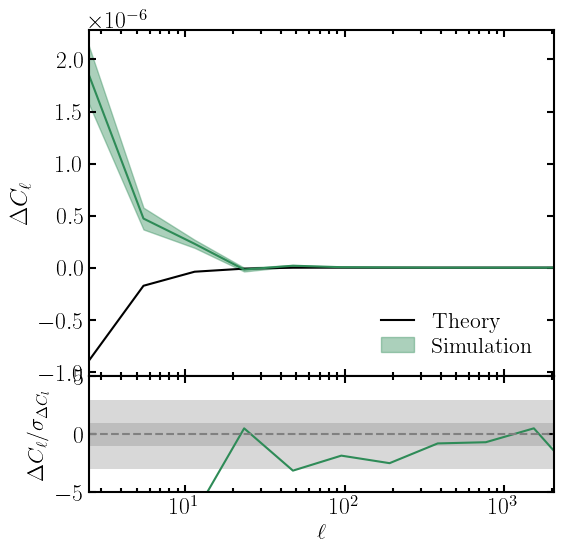

In [12]:
deprojection_bias_cls = wsp.decouple_cell(deprojection_bias_cls)[0]

### look at the individual differences between the cls wo systematics and the deprojected cls
path_Cls = f'{pathSALMO}ClsSALMO/'
Cls_files = [f for f in os.listdir(path_Cls) if f'Cls_' in f]

Nsim_Cls = len(Cls_files)


bias0 = clsD_mean - cls0_mean
biasRew = clsD_mean - clsrew_mean

bias0_arr = np.zeros((Nsim_Cls, bins.get_n_bands()))
biasRew_arr = np.zeros((Nsim_Cls, bins.get_n_bands()))
for i, file in enumerate(Cls_files):
    Cls_df = pd.read_csv(path_Cls + file)

    cls0 = Cls_df['Cl_NoVD_rmshotnoise'].to_numpy()
    clsD = Cls_df['Cl_Deprojected_rmshotnoise'].to_numpy()
    clsRew = Cls_df['Cl_Reweighted_rmshotnoise'].to_numpy()
   

    
    bias0_arr[i] = clsD - cls0
    biasRew_arr[i] = clsD - clsRew
 
unc0 = np.sqrt(np.nanmean((bias0_arr - bias0)**2, axis=0)) / np.sqrt(Nsim_Cls)
uncRew = np.sqrt(np.nanmean((biasRew_arr - biasRew)**2, axis=0)) / np.sqrt(Nsim_Cls)

### plot the deprojection bias
fig = plt.figure(figsize=(6,6))
fig_grid = fig.add_gridspec(1,1)

plots_grid = fig_grid[0,0].subgridspec(2,1,hspace=0, height_ratios=[3,1])
axs = plots_grid.subplots()

axs[0].plot(ells, deprojection_bias_cls, color='black', label='Theory')
axs[0].plot(ells, bias0, color='seagreen')
#axs[0].fill_between(ells, bias0+ unc0, bias0- unc0, color='indianred', alpha=0.4, label='$C_{\\ell}^{Dep} - C_{\\ell}^0$')
axs[0].fill_between(ells, bias0+ unc0, bias0- unc0, color='seagreen', alpha=0.4, label='Simulation')
#axs[0].plot(ells, biasRew, color='orange')
#axs[0].fill_between(ells, biasRew+ uncRew, biasRew- uncRew, color='orange', alpha=0.4, label='$C_{\\ell}^{Dep} - C_{\\ell}^{Rew}$')
axs[0].legend(loc='lower right', frameon=False)
axs[0].set_xscale('log')
axs[0].set_ylabel('$\\Delta C_\\ell$')
axs[0].set_xlim(ells[0], 2*nside)


axs[1].plot(ells, (deprojection_bias_cls - bias0)/ unc0, color='seagreen')
#axs[1].plot(ells, (deprojection_bias_cls - biasRew)/ uncRew, color='orange')
axs[1].axhline(0,ls='--', color='grey')
axs[1].set_ylabel('$\\Delta C_\\ell/\\sigma_{\\Delta C_l}$', fontsize=16)
axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[1].fill_between(y1=-3, y2=3, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[1].set_ylim(-5,5)
axs[1].set_xlabel(f'$\\ell$', fontsize=16)
axs[1].set_xlim(ells[0], 2*nside)
axs[1].set_xscale('log')
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}deprojection_bias_cls.png')
plt.show()

#### FSB

In [55]:
mpl.rcParams['hatch.linewidth'] = .5

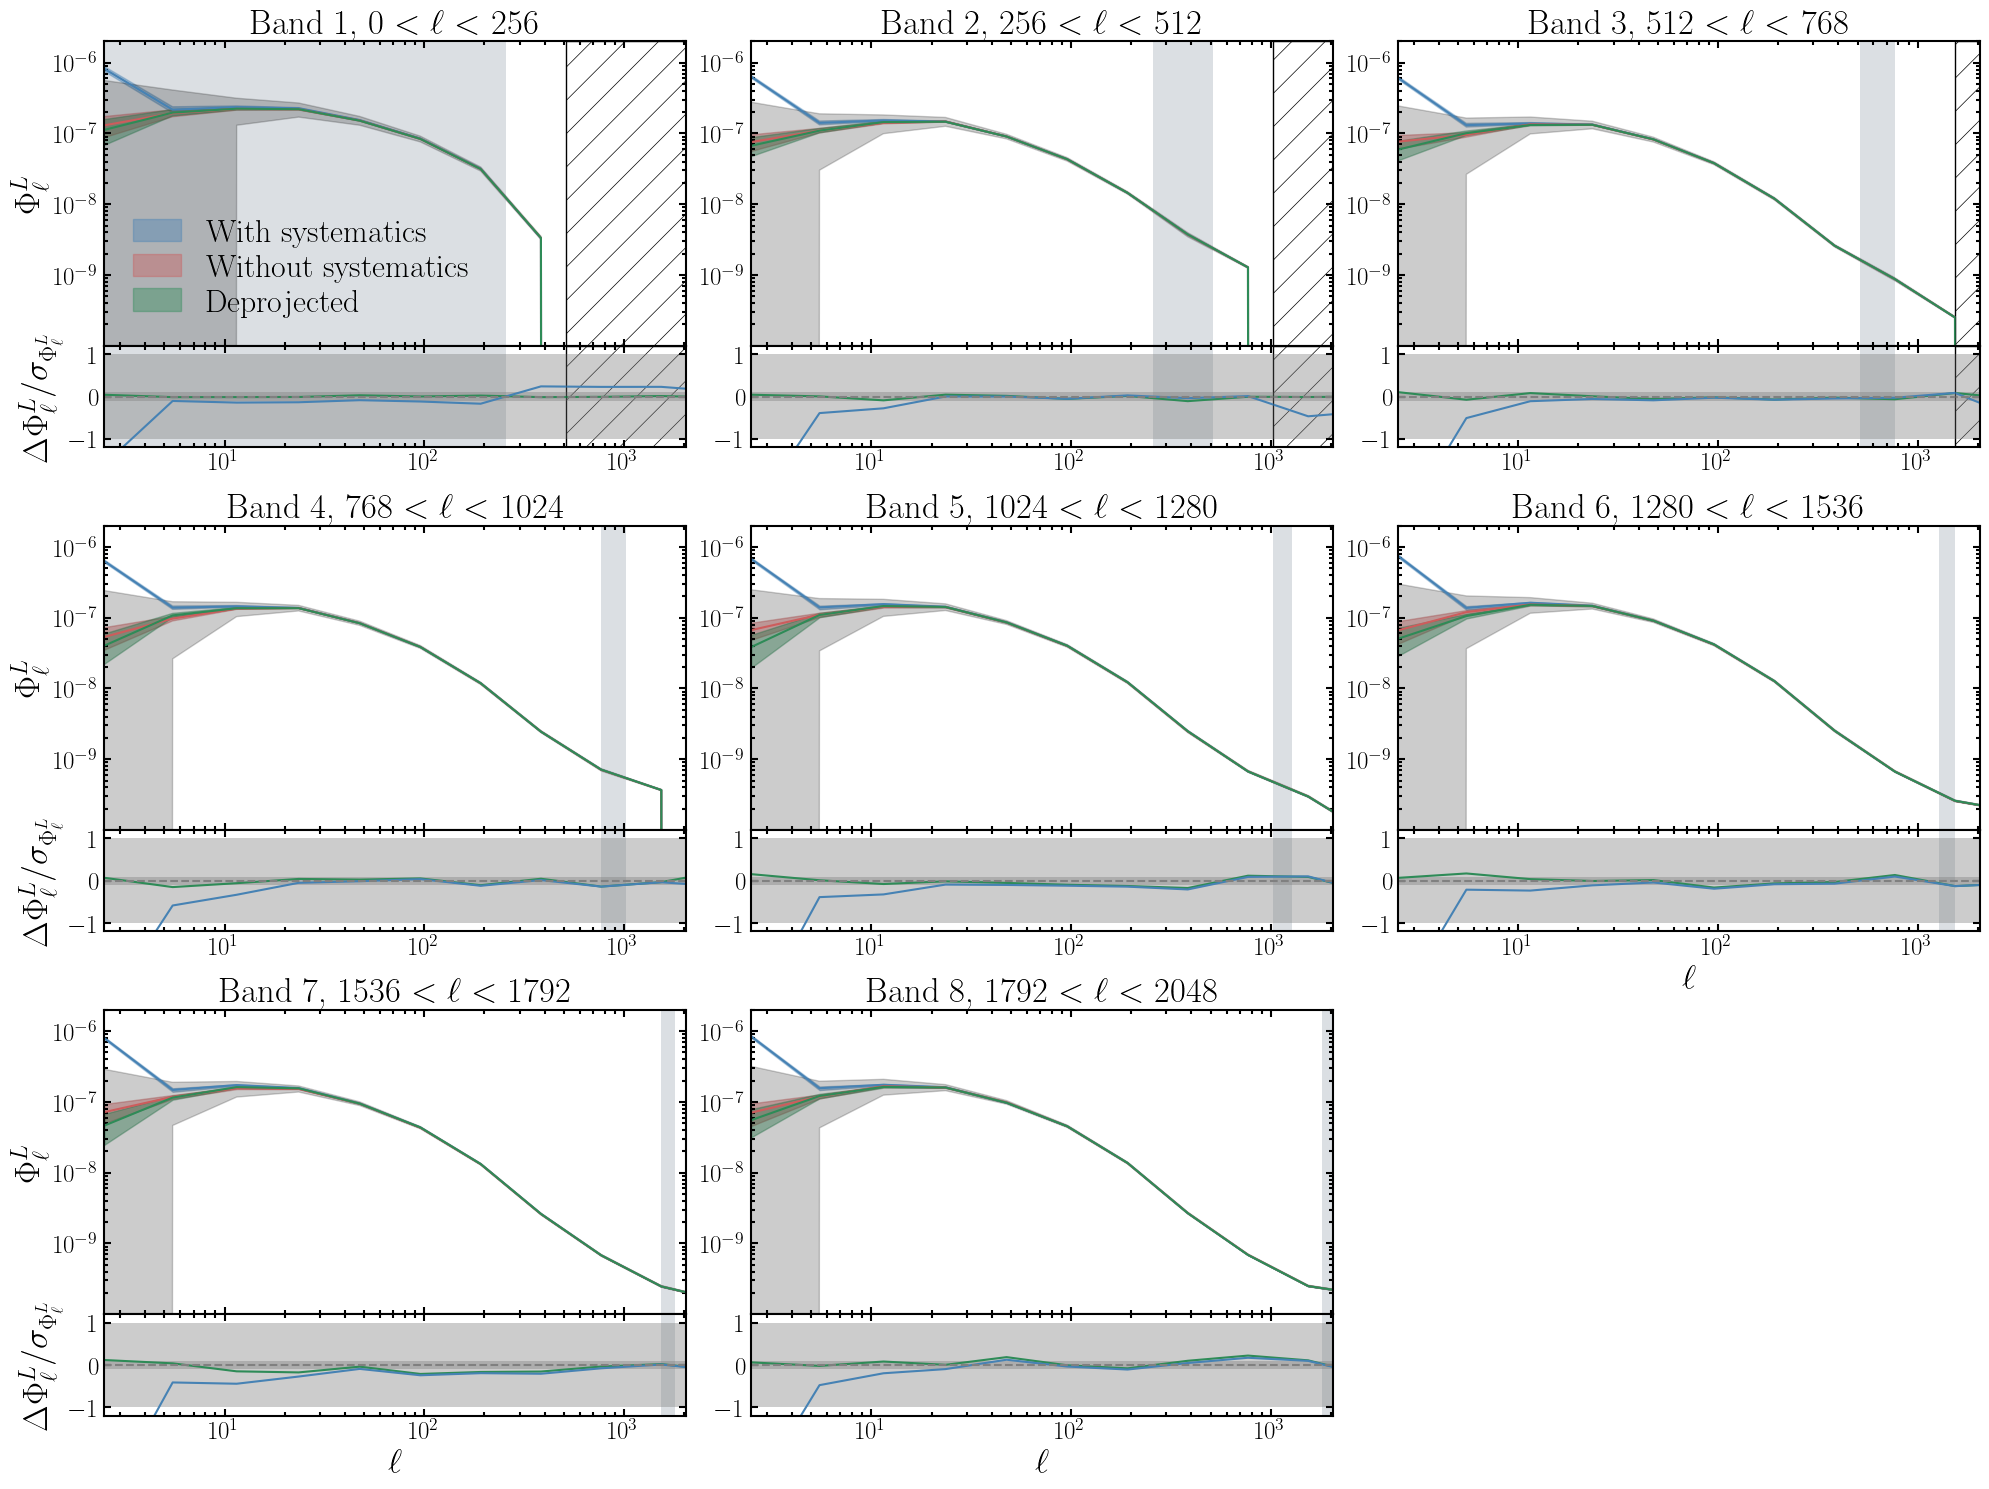

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

fsb = pd.read_csv(f'{pathSALMO}FsbSALMO/mean_FSB.data')
#fsb_filt = pd.read_csv(f'/vol/aleph/data/mheld/salmo/simulation_140/FsbSALMO/MeanFSB.data')

ells = fsb['ell'].to_numpy()

#fig = plt.figure(figsize=(25,10))
#bands_grid = fig.add_gridspec(2,4)
fig = plt.figure(figsize=(20,15))
bands_grid = fig.add_gridspec(3,3)

mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["xtick.labelsize"] = 18
## plot the fsb
i=0
for j in range(nbands):
    fsb1_mean = fsb[f'FSB_VD_bin{j}'].to_numpy()
    fsb0_mean = fsb[f'FSB_NoVD_bin{j}'].to_numpy()
    fsbD_mean = fsb[f'FSB_Deprojected_bin{j}'].to_numpy()
    fsb1_unc = fsb[f'FSB_VD_bin{j} unc'].to_numpy()
    fsb0_unc = fsb[f'FSB_NoVD_bin{j} unc'].to_numpy()
    fsbD_unc = fsb[f'FSB_Deprojected_bin{j} unc'].to_numpy()

    plots_grid = bands_grid[j//3, j%3].subgridspec(2,1,hspace=0, height_ratios=[3,1])
    axs = plots_grid.subplots()

    ## plot FSB
    axs[0].set_title(f'Band {j+1}, {j*dell} $< \\ell <$ {(j+1)*dell}', fontsize=25)
    axs[0].plot(ells, fsb1_mean, 'steelblue')
    axs[0].plot(ells, fsb0_mean, 'indianred')
    axs[0].plot(ells, fsbD_mean, 'seagreen')
    #axs[0].plot(ells, fsb[f'FSB_NoVD_Fullsky_bin{j}'].to_numpy() / fsky, 'sandybrown', label='no VD fullsky')
    #axs[0].plot(ells, fsb[f'FSB_Deprojected_Fullsky_bin{j}'].to_numpy() / fsky, 'lavender', label='deproject fullsky')
    axs[0].fill_between(ells, fsb1_mean- fsb1_unc, fsb1_mean+ fsb1_unc, color='steelblue', alpha=0.4, label='With systematics')
    axs[0].fill_between(ells, fsb0_mean- fsb0_unc, fsb0_mean+ fsb0_unc, color='indianred', alpha=0.4, label='Without systematics')
    axs[0].fill_between(ells, fsbD_mean- fsbD_unc, fsbD_mean+ fsbD_unc, color='seagreen', alpha=0.4, label='Deprojected')
    axs[0].fill_between(ells, fsb0_mean- fsb0_unc*10, fsb0_mean+ fsb0_unc*10, color='black', alpha=0.2)
    axs[0].axvspan(j*dell, (j+1)*dell, facecolor='slategrey', alpha=0.25, zorder=0)
    axs[0].set_yscale('log')
    axs[0].set_xlim(xmin=ells[0], xmax=2*nside)
    axs[0].set_ylim(1e-10,2e-6)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    ## plot relative deviation between declas and simulation
    devD = (fsb0_mean - fsbD_mean) / fsb0_unc / np.sqrt(Nsim)
    devD2 = (fsb0_mean - fsb1_mean) / fsb0_unc / np.sqrt(Nsim)
    #devD2 = (fsb0_mean - fsb1_mean) / fsb0_unc

    axs[1].plot(ells, devD, 'seagreen')
    axs[1].plot(ells, devD2, 'steelblue')
    axs[1].axhline(ls='--', color='grey')
    axs[1].axvspan(j*dell, (j+1)*dell, facecolor='slategrey', alpha=0.25, zorder=0)
    axs[1].set_ylim(-1.2,1.2)
    axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.4, color='grey', edgecolor=None)
    axs[1].fill_between(y1=-.1, y2=.1, x=ells, alpha=0.4, color='grey', edgecolor=None)

    


    axs[1].set_xscale('log')
    axs[1].set_xlim(ells[0], 2*nside)

    axs[0].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='black', fc='white', alpha=1, zorder=0)
    axs[0].axvline(2*(j+1)*dell, color='black', alpha=0.5, lw=0.5)
    axs[1].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='black', fc='white', alpha=1, zorder=0)
    axs[1].axvline(2*(j+1)*dell, color='black', alpha=0.5, lw=0.5)

    axs[0].set_yticks([1e-6, 1e-7, 1e-8, 1e-9])
    if j in [0,3, 6]:
        axs[0].set_ylabel(f'$\\Phi^L_\\ell$', fontsize=25)
        axs[1].set_ylabel('$\\Delta\\Phi^L_\\ell /\\sigma_{\\Phi_\\ell^L}$', fontsize=25)

    if j == 0:
        axs[0].legend(loc='lower left', frameon=False, fontsize=23)
    if j in [7,6,5]:
        axs[1].set_xlabel(f'$\\ell$', fontsize=25)


plt.tight_layout()    
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}FSB_SALMO.png')

plt.show()

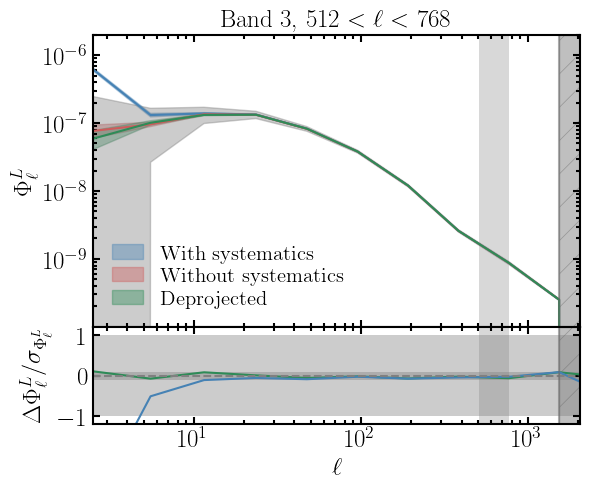

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

fsb = pd.read_csv(f'{pathSALMO}FsbSALMO/mean_FSB.data')
#fsb_filt = pd.read_csv(f'/vol/aleph/data/mheld/salmo/simulation_140/FsbSALMO/MeanFSB.data')

ells = fsb['ell'].to_numpy()

fig = plt.figure(figsize=(6,5))
bands_grid = fig.add_gridspec(1,1)

mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["xtick.labelsize"] = 18
## plot the fsb
#i=0
#for j in range(nbands):
j=2
fsb1_mean = fsb[f'FSB_VD_bin{j}'].to_numpy()
fsb0_mean = fsb[f'FSB_NoVD_bin{j}'].to_numpy()
fsbD_mean = fsb[f'FSB_Deprojected_bin{j}'].to_numpy()
fsb1_unc = fsb[f'FSB_VD_bin{j} unc'].to_numpy()
fsb0_unc = fsb[f'FSB_NoVD_bin{j} unc'].to_numpy()
fsbD_unc = fsb[f'FSB_Deprojected_bin{j} unc'].to_numpy()

plots_grid = bands_grid[0].subgridspec(2,1,hspace=0, height_ratios=[3,1])
axs = plots_grid.subplots()

## plot FSB
axs[0].set_title(f'Band {j+1}, {j*dell} $< \\ell <$ {(j+1)*dell}', fontsize=18)
axs[0].plot(ells, fsb1_mean, 'steelblue')
axs[0].plot(ells, fsb0_mean, 'indianred')
axs[0].plot(ells, fsbD_mean, 'seagreen')
#axs[0].plot(ells, fsb[f'FSB_NoVD_Fullsky_bin{j}'].to_numpy() / fsky, 'sandybrown', label='no VD fullsky')
#axs[0].plot(ells, fsb[f'FSB_Deprojected_Fullsky_bin{j}'].to_numpy() / fsky, 'lavender', label='deproject fullsky')
axs[0].fill_between(ells, fsb1_mean- fsb1_unc, fsb1_mean+ fsb1_unc, color='steelblue', alpha=0.4, label='With systematics')
axs[0].fill_between(ells, fsb0_mean- fsb0_unc, fsb0_mean+ fsb0_unc, color='indianred', alpha=0.4, label='Without systematics')
axs[0].fill_between(ells, fsbD_mean- fsbD_unc, fsbD_mean+ fsbD_unc, color='seagreen', alpha=0.4, label='Deprojected')
axs[0].fill_between(ells, fsb0_mean- fsb0_unc*10, fsb0_mean+ fsb0_unc*10, color='grey', alpha=0.4)
axs[0].axvspan(j*dell, (j+1)*dell, facecolor='grey', alpha=0.3)
axs[0].set_yscale('log')
axs[0].set_xlim(xmin=ells[0], xmax=2*nside)
axs[0].set_ylim(1e-10,2e-6)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

## plot relative deviation between declas and simulation
devD = (fsb0_mean - fsbD_mean) / fsb0_unc / np.sqrt(Nsim)
devD2 = (fsb0_mean - fsb1_mean) / fsb0_unc / np.sqrt(Nsim)
#devD2 = (fsb0_mean - fsb1_mean) / fsb0_unc

axs[1].plot(ells, devD, 'seagreen')
axs[1].plot(ells, devD2, 'steelblue')
axs[1].axhline(ls='--', color='grey')
axs[1].axvspan(j*dell, (j+1)*dell, facecolor='grey', alpha=0.3)
axs[1].set_ylim(-1.2,1.2)
axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.4, color='grey', edgecolor=None)
axs[1].fill_between(y1=-.1, y2=.1, x=ells, alpha=0.4, color='grey', edgecolor=None)



axs[1].set_xlabel(f'$\\ell$', fontsize=18)
axs[1].set_xscale('log')
axs[1].set_xlim(ells[0], 2*nside)

axs[0].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='dimgrey', fc='grey', alpha=0.5)
axs[0].axvline(2*(j+1)*dell, color='dimgrey', alpha=0.5)
axs[1].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='dimgrey', fc='grey', alpha=0.5)
axs[1].axvline(2*(j+1)*dell, color='dimgrey', alpha=0.5)

axs[0].set_yticks([1e-6, 1e-7, 1e-8, 1e-9])

axs[0].set_ylabel(f'$\\Phi^L_\\ell$', fontsize=18)
axs[1].set_ylabel('$\\Delta\\Phi^L_\\ell /\\sigma_{\\Phi_\\ell^L}$', fontsize=18)

axs[0].legend(loc='lower left', frameon=False)

plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}FSB_SALMO_band3.png')
plt.show()

#### Deprojection bias (comparison with uncertainty)

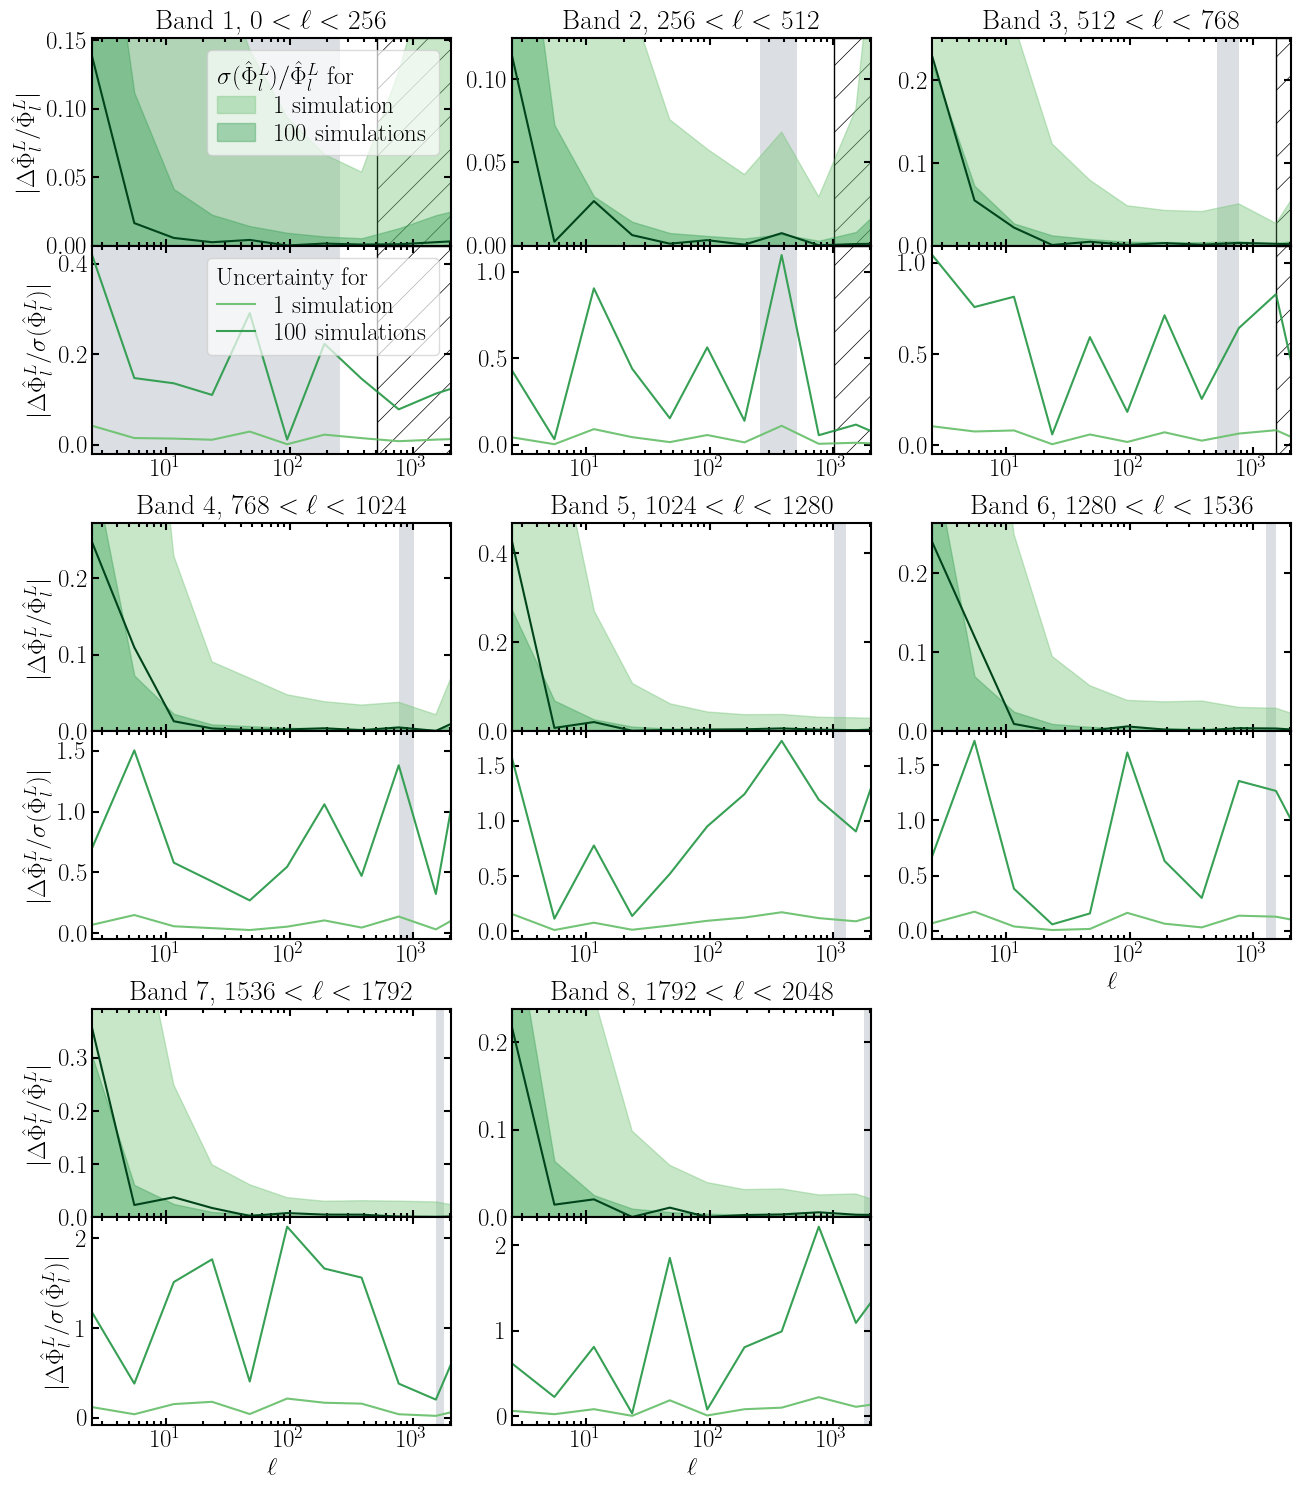

In [58]:
import matplotlib as mpl 

fig = plt.figure(figsize=(13,15))
bands_grid = fig.add_gridspec(3,3)

nsims = [1, 100]


cmap = mpl.colormaps.get_cmap('Greens')(np.linspace(0.5,1,4))

df_fsb = pd.read_csv(f'{pathSALMO}FsbSALMO/mean_FSB.data')

for j in range(nbands):
    fsb0 = df_fsb[f'FSB_NoVD_bin{j}'].copy()
    bias = df_fsb[f'FSB_Deprojected_bin{j}'] - fsb0
    unc = df_fsb[f'FSB_NoVD_bin{j} unc'].copy() * np.sqrt(100)

    plots_grid = bands_grid[j//3, j%3].subgridspec(2,1,hspace=0)
    axs = plots_grid.subplots()
    axs[0].set_title(f'Band {j+1}, {j*dell} $< \\ell <$ {(j+1)*dell}', fontsize=20)
    axs[0].plot(ells, abs(bias / fsb0), color=cmap[-1])
    for i, n in enumerate(nsims):
        unc_up = abs(bias / fsb0**2 *unc/np.sqrt(n))
        unc_down = abs(bias / fsb0 - bias / fsb0**2 *unc/np.sqrt(n))
        unc_up_copy = unc_up.copy()
        unc_up[0] = unc_down[0]
        unc_down[0] = unc_up_copy[0]
        if n == 1:
            unc_down[:2] = -unc_down[:2]

        
        if n ==1:
            label = f'{n} simulation'
        else:
            label = f'{n} simulations'
        axs[1].plot(ells, abs(bias/(unc/ np.sqrt(n))), label=label, color=cmap[i])
        axs[0].fill_between(ells, abs((unc/ np.sqrt(n)) / fsb0), 0, color=cmap[i], alpha=0.4, label=label)

    axs[0].set_xscale('log')
    axs[0].set_ylim(ymax = max(abs(bias/ fsb0))*1.1, ymin = 0)
    axs[0].set_xlim(ells[0], 2*nside)
    axs[0].axvspan(j*dell, (j+1)*dell, facecolor='slategrey', alpha=0.25, zorder=0)
    axs[1].set_xscale('log')
    axs[1].set_xlim(ells[0], 2*nside)
    axs[1].axvspan(j*dell, (j+1)*dell, facecolor='slategrey', alpha=0.25, zorder=0)

    if j == 0:
        leg1 = axs[1].legend(title='Uncertainty for', alignment='left', framealpha=0.7, fontsize=18, loc='upper right')
        leg2 = axs[0].legend(title='$\\sigma(\\hat{\\Phi}^L_l) / \\hat{\\Phi}^L_l$ for', alignment='left', framealpha=0.7, fontsize=18, loc='upper right')
        plt.setp(leg1.get_title(),fontsize=18)
        plt.setp(leg2.get_title(),fontsize=18)
    if j in [7,6,5]:
        axs[1].set_xlabel('$\\ell$')

    axs[0].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='black', fc='white', alpha=1, zorder=0)
    axs[0].axvline(2*(j+1)*dell, color='black', alpha=0.5, lw=0.5)
    axs[1].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='black', fc='white', alpha=1, zorder=0)
    axs[1].axvline(2*(j+1)*dell, color='black', alpha=0.5, lw=0.5)

    if j in [0,3, 6]:
        axs[1].set_ylabel('$ |\\Delta \\hat{\\Phi}^L_l/\\sigma(\\hat{\\Phi}^L_l)| $')
        axs[0].set_ylabel('$ |\\Delta \\hat{\\Phi}^L_l / \\hat{\\Phi}^L_l | $')

plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}deprojection_bias_fsb.png')
plt.show()

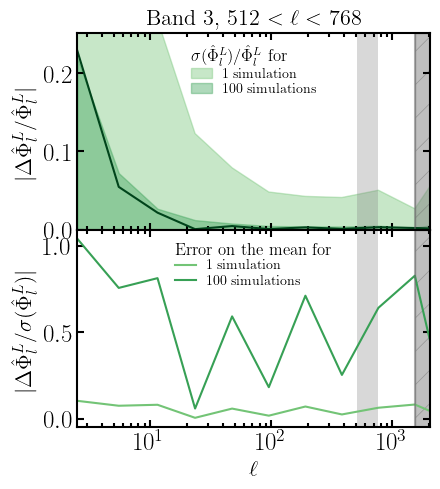

In [59]:
import matplotlib as mpl 

fig = plt.figure(figsize=(4.5,5))
bands_grid = fig.add_gridspec(1,1)

nsims = [1, 100]


cmap = mpl.colormaps.get_cmap('Greens')(np.linspace(0.5,1,4))

df_fsb = pd.read_csv(f'{pathSALMO}FsbSALMO/mean_FSB.data')

j=2
fsb0 = df_fsb[f'FSB_NoVD_bin{j}'].copy()
bias = df_fsb[f'FSB_Deprojected_bin{j}'] - fsb0
unc = df_fsb[f'FSB_NoVD_bin{j} unc'].copy() * np.sqrt(100)

plots_grid = bands_grid[0].subgridspec(2,1,hspace=0)
axs = plots_grid.subplots()
axs[0].set_title(f'Band {j+1}, {j*dell} $< \\ell <$ {(j+1)*dell}', fontsize=16)
axs[0].plot(ells, abs(bias / fsb0), color=cmap[-1])
for i, n in enumerate(nsims):
    unc_up = abs(bias / fsb0**2 *unc/np.sqrt(n))
    unc_down = abs(bias / fsb0 - bias / fsb0**2 *unc/np.sqrt(n))
    unc_up_copy = unc_up.copy()
    unc_up[0] = unc_down[0]
    unc_down[0] = unc_up_copy[0]
    if n == 1:
        unc_down[:2] = -unc_down[:2]

    
    if n ==1:
        label = f'{n} simulation'
    else:
        label = f'{n} simulations'
    axs[1].plot(ells, abs(bias/(unc/ np.sqrt(n))), label=label, color=cmap[i])
    axs[0].fill_between(ells, abs((unc/ np.sqrt(n)) / fsb0), 0, color=cmap[i], alpha=0.4, label=label)

axs[0].set_xscale('log')
axs[0].set_ylim(ymax = max(abs(bias/ fsb0))*1.1, ymin = 0)
axs[0].set_xlim(ells[0], 2*nside)
axs[0].axvspan(j*dell, (j+1)*dell, facecolor='grey', alpha=0.3)
axs[1].set_xscale('log')
axs[1].set_xlim(ells[0], 2*nside)
axs[1].axvspan(j*dell, (j+1)*dell, facecolor='grey', alpha=0.3)


axs[1].legend(title='Error on the mean for', alignment='left', framealpha=0, fontsize=10, loc='upper center', title_fontsize=12)
axs[0].legend(title='$\\sigma(\\hat{\\Phi}^L_l) / \\hat{\\Phi}^L_l$ for', alignment='left', framealpha=0, fontsize=10, loc='upper center', title_fontsize=12)

axs[1].set_xlabel('$\\ell$', fontsize=16)

axs[0].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='dimgrey', fc='grey', alpha=0.5)
axs[0].axvline(2*(j+1)*dell, color='dimgrey', alpha=0.5)
axs[1].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='dimgrey', fc='grey', alpha=0.5)
axs[1].axvline(2*(j+1)*dell, color='dimgrey', alpha=0.5)


axs[1].set_ylabel('$ |\\Delta \\hat{\\Phi}^L_l/\\sigma(\\hat{\\Phi}^L_l)| $', fontsize=16)
axs[0].set_ylabel('$ |\\Delta \\hat{\\Phi}^L_l / \\hat{\\Phi}^L_l | $', fontsize=16)

plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}deprojection_bias_fsb_band3.png')
plt.show()

#### first term of the analytical deprojection bias

In [60]:
import re
fsky = np.sum(maskSALMO) / hp.nside2npix(nside)

files = [f for f in os.listdir(f'{pathSALMO}FsbSALMO/') if 'FSB_' in f]
Nsim = len(files)
print(files)
inds = []
for file in files:
    inds.append(np.uint(re.findall(r'\d+', file)[0]))


file_ex = pd.read_csv(f'{pathSALMO}FsbSALMO/{files[0]}')

results = {}


fsb_bias_arr = np.zeros((nbands, Nsim, bins.get_n_bands()))
for i, ind in enumerate(inds):
    df_fsb = pd.read_csv(f'{pathSALMO}FsbSALMO/FSB_{ind}.data')
    for j in range(nbands):
        fsb1 = df_fsb[f'FSB_Deprojected_bin{j}'].to_numpy() #/ fsky
        fsb0 = df_fsb[f'FSB_NoVD_bin{j}'].to_numpy() #/ fsky

        fsb_bias_arr[j][i] = fsb1- fsb0


for j in range(nbands):
    results[f'Deprojection_Bias_FSB_bin{j}'] = np.nanmean(fsb_bias_arr[j],axis=0)
    results[f'Deprojection_Bias_FSB_bin{j}_Uncertainty'] = np.nanstd(fsb_bias_arr[j], axis=0) / np.sqrt(Nsim)

['FSB_32.data', 'FSB_35.data', 'FSB_10.data', 'FSB_100.data', 'FSB_43.data', 'FSB_17.data', 'FSB_64.data', 'FSB_3.data', 'FSB_85.data', 'FSB_67.data', 'FSB_22.data', 'FSB_23.data', 'FSB_69.data', 'FSB_8.data', 'FSB_98.data', 'FSB_91.data', 'FSB_54.data', 'FSB_2.data', 'FSB_7.data', 'FSB_9.data', 'FSB_47.data', 'FSB_21.data', 'FSB_86.data', 'FSB_62.data', 'FSB_18.data', 'FSB_24.data', 'FSB_95.data', 'FSB_76.data', 'FSB_51.data', 'FSB_12.data', 'FSB_42.data', 'FSB_63.data', 'FSB_46.data', 'FSB_57.data', 'FSB_75.data', 'FSB_45.data', 'FSB_30.data', 'FSB_78.data', 'FSB_74.data', 'FSB_4.data', 'FSB_37.data', 'FSB_71.data', 'FSB_40.data', 'FSB_36.data', 'FSB_58.data', 'FSB_56.data', 'FSB_68.data', 'FSB_83.data', 'FSB_11.data', 'FSB_93.data', 'FSB_49.data', 'FSB_14.data', 'FSB_33.data', 'FSB_16.data', 'FSB_6.data', 'FSB_26.data', 'FSB_25.data', 'FSB_13.data', 'FSB_28.data', 'FSB_61.data', 'FSB_92.data', 'FSB_41.data', 'FSB_72.data', 'FSB_44.data', 'FSB_82.data', 'FSB_65.data', 'FSB_79.data', 

In [61]:
files = [f for f in os.listdir(f'{pathSALMO}FSB_depbias/') if 't1' in f]
Nsim = len(files)
print(files)
inds = []
for file in files:
    inds.append(np.uint(re.findall(r'\d+', file)[0]))
    
file_ex = pd.read_csv(f'{pathSALMO}FSB_depbias/{files[0]}')


ells_lin = np.arange(0,3*nside)
t1_arr = np.zeros((nbands, Nsim, len(ells)))
for i, file in enumerate(files):
    df_t1 = pd.read_csv(f'{pathSALMO}FSB_depbias/{file}')
    for j in range(nbands):
        t1 = df_t1[f'FSB first term bin {j}'].to_numpy()
        t1 = wsp.decouple_cell([t1])[0]
        t1_arr[j][i] = t1

#results = {}   
for j in range(nbands):
    results[f'FSB first term bin {j}'] = np.nanmean(t1_arr[j],axis=0)
    results[f'FSB first term bin {j}_Uncertainty'] = np.nanstd(t1_arr[j], axis=0) / np.sqrt(Nsim)

['t1_11.data', 't1_1.data', 't1_5.data', 't1_91.data', 't1_25.data', 't1_49.data', 't1_9.data', 't1_26.data', 't1_59.data', 't1_16.data', 't1_93.data', 't1_15.data', 't1_6.data', 't1_96.data', 't1_32.data', 't1_27.data', 't1_85.data', 't1_97.data', 't1_18.data', 't1_63.data', 't1_43.data', 't1_83.data', 't1_57.data', 't1_12.data', 't1_86.data', 't1_34.data', 't1_68.data', 't1_92.data', 't1_23.data', 't1_13.data', 't1_47.data', 't1_14.data', 't1_72.data', 't1_98.data', 't1_17.data', 't1_55.data', 't1_42.data', 't1_30.data', 't1_22.data', 't1_90.data', 't1_75.data', 't1_2.data', 't1_58.data', 't1_82.data', 't1_65.data', 't1_39.data', 't1_79.data', 't1_28.data', 't1_69.data', 't1_88.data', 't1_45.data', 't1_24.data', 't1_61.data', 't1_76.data', 't1_71.data', 't1_100.data', 't1_77.data', 't1_73.data', 't1_3.data', 't1_84.data', 't1_41.data', 't1_62.data', 't1_89.data', 't1_80.data', 't1_87.data', 't1_56.data', 't1_40.data', 't1_52.data', 't1_95.data', 't1_29.data', 't1_31.data', 't1_53.dat

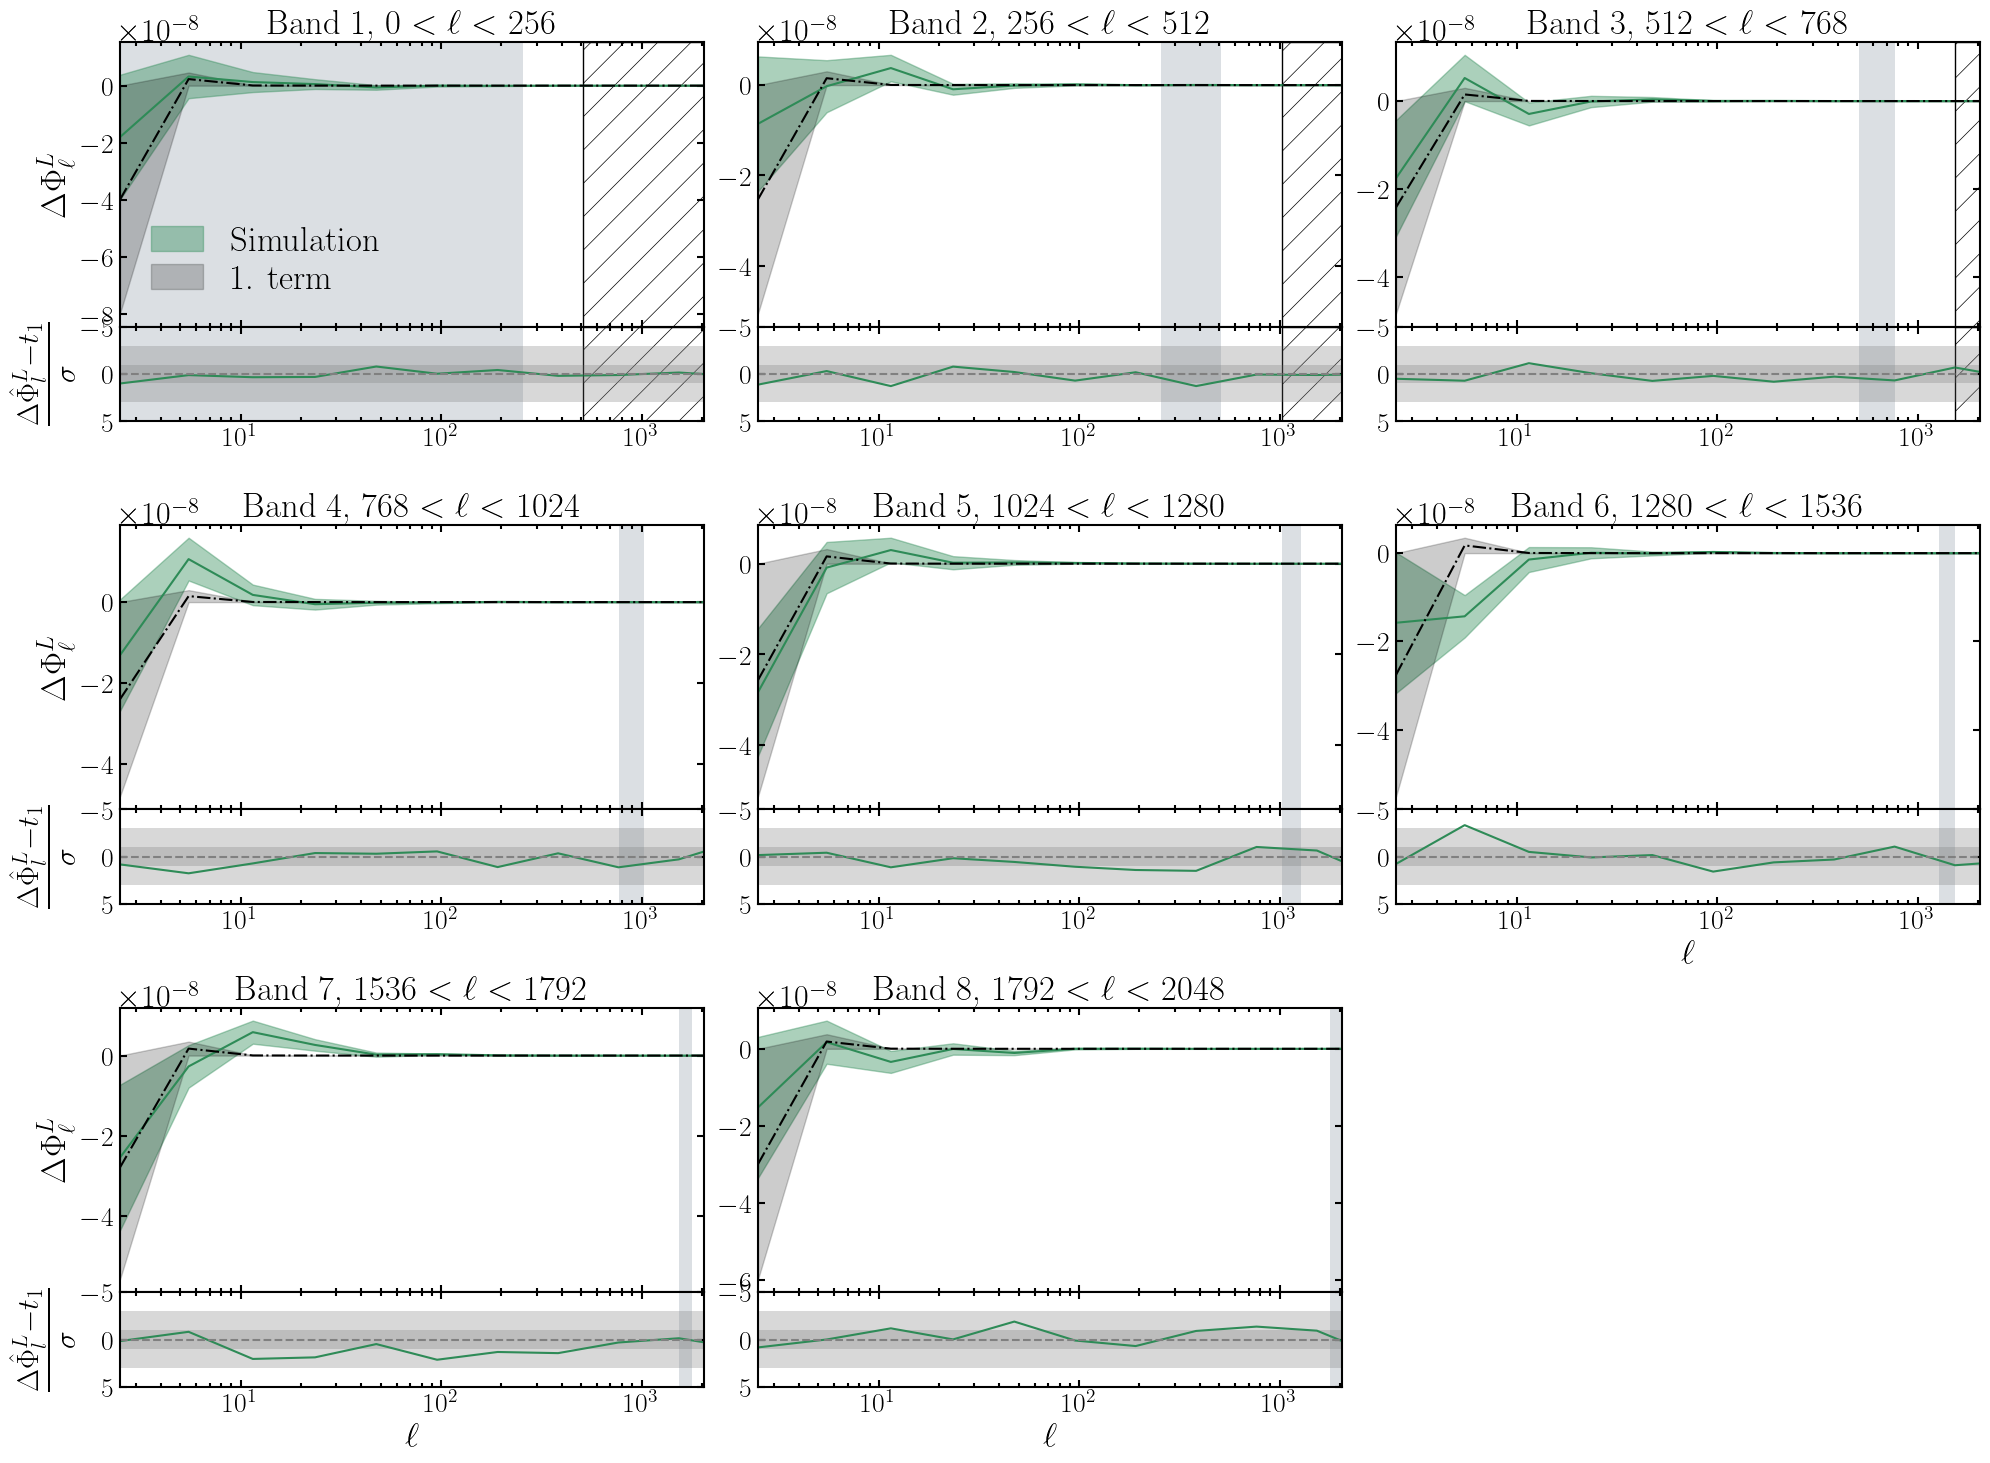

In [62]:
#fig = plt.figure(figsize=(25,10))
#bands_grid = fig.add_gridspec(2,4)
fig = plt.figure(figsize=(20,15))
bands_grid = fig.add_gridspec(3,3)
## plot the fsb

df_fsb = pd.read_csv(f'{pathSALMO}FsbSALMO/mean_FSB.data')

i=0
for j in range(nbands):
    fsb0 = df_fsb[f'FSB_NoVD_bin{j}'].copy()
    bias = results[f'Deprojection_Bias_FSB_bin{j}']
    unc = results[f'Deprojection_Bias_FSB_bin{j}_Uncertainty']
    
    t1 = results[f'FSB first term bin {j}']
    t1_unc = results[f'FSB first term bin {j}']

    dev = (bias - t1) / unc




    plots_grid = bands_grid[j//3, j%3].subgridspec(2,1,hspace=0, height_ratios=[3,1])
    axs = plots_grid.subplots()

    axs[0].plot(ells, bias, color='seagreen')
    axs[0].plot(ells, t1, color='black', linestyle='-.')
    axs[0].fill_between(ells, bias- unc, bias + unc, alpha=0.4, color='seagreen', label='Simulation')
    axs[0].fill_between(ells, t1- abs(t1_unc), t1 + abs(t1_unc), alpha=0.2, color='black', label='1. term')
    axs[1].plot(ells, dev, 'seagreen')


    axs[0].set_title(f'Band {j+1}, {j*dell} $< \\ell <$ {(j+1)*dell}', fontsize=25)
    axs[0].axvspan(j*dell, (j+1)*dell, facecolor='slategrey', alpha=0.25, zorder=0)
    axs[0].set_xscale('log')
    axs[0].set_xlim(ells[0], 2*nside)
    axs[0].set_xlabel('$\\ell$', fontsize=25)
    if j ==0:
        axs[0].legend(frameon=False, loc='lower left', fontsize=25)


    axs[1].axhline(0,ls='--', color='grey')
    axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
    axs[1].fill_between(y1=-3, y2=3, x=ells, alpha=0.3, color='grey', edgecolor=None)
    axs[1].axvspan(j*dell, (j+1)*dell, facecolor='slategrey', alpha=0.25, zorder=0)
    axs[1].set_xscale('log')
    axs[1].set_ylim(ymax = -5, ymin = 5)
    axs[1].set_xlim(ells[0], 2*nside)
    
    axs[0].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='black', fc='white', alpha=1, zorder=0)
    axs[0].axvline(2*(j+1)*dell, color='black', alpha=0.5, lw=.5)
    axs[1].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='black', fc='white', alpha=1, zorder=0)
    axs[1].axvline(2*(j+1)*dell, color='black', alpha=0.5, lw=.5)
    
    
    if j in [0,3,6]:
        axs[0].set_ylabel(f'$\\Delta\\Phi^L_\\ell$', fontsize=25)
        axs[1].set_ylabel('$\\frac{\\Delta\\hat{\\Phi}^L_l- t_1}{\\sigma}$', fontsize=31)
    
    if j in [7,6,5]:
        axs[1].set_xlabel(f'$\\ell$', fontsize=25)
    axs[0].yaxis.offsetText.set_fontsize(23)
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}analyt_deprojection_bias_FSB.png')
plt.show()

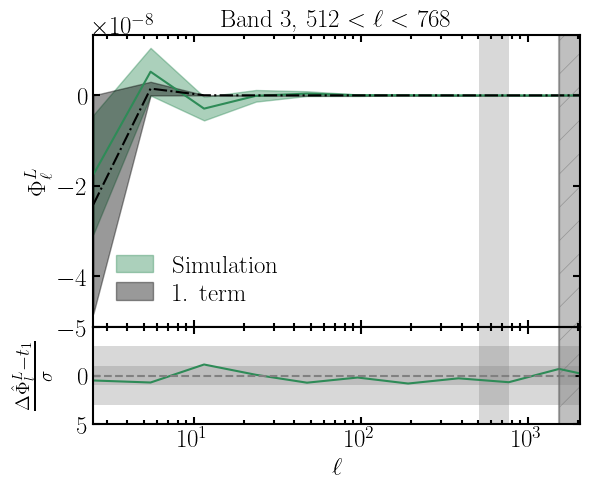

In [63]:
fig = plt.figure(figsize=(6,5))
bands_grid = fig.add_gridspec(1,1)
## plot the fsb

df_fsb = pd.read_csv(f'{pathSALMO}FsbSALMO/mean_FSB.data')

j=2
fsb0 = df_fsb[f'FSB_NoVD_bin{j}'].copy()
bias = results[f'Deprojection_Bias_FSB_bin{j}']
unc = results[f'Deprojection_Bias_FSB_bin{j}_Uncertainty']

t1 = results[f'FSB first term bin {j}']
t1_unc = results[f'FSB first term bin {j}']

dev = (bias - t1) / unc




plots_grid = bands_grid[0].subgridspec(2,1,hspace=0, height_ratios=[3,1])
axs = plots_grid.subplots()

axs[0].plot(ells, bias, color='seagreen')
axs[0].plot(ells, t1, color='black', linestyle='-.')
axs[0].fill_between(ells, bias- unc, bias + unc, alpha=0.4, color='seagreen', label='Simulation')
axs[0].fill_between(ells, t1- abs(t1_unc), t1 + abs(t1_unc), alpha=0.4, color='black', label='1. term')
axs[1].plot(ells, dev, 'seagreen')


axs[0].set_title(f'Band {j+1}, {j*dell} $< \\ell <$ {(j+1)*dell}', fontsize=18)
axs[0].axvspan(j*dell, (j+1)*dell, facecolor='grey', alpha=0.3)
axs[0].set_xscale('log')
axs[0].set_xlim(ells[0], 2*nside)
axs[0].set_xlabel('$\\ell$', fontsize=25)
axs[0].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='dimgrey', fc='grey', alpha=0.5)
axs[0].axvline(2*(j+1)*dell, color='dimgrey', alpha=0.5)

axs[0].legend(frameon=False, loc='lower left', fontsize=18)


axs[1].axhline(0,ls='--', color='grey')
axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[1].fill_between(y1=-3, y2=3, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[1].axvspan(j*dell, (j+1)*dell, facecolor='grey', alpha=0.3)
axs[1].set_xscale('log')
axs[1].set_ylim(ymax = -5, ymin = 5)
axs[1].set_xlim(ells[0], 2*nside)
axs[1].axvspan(2*(j+1)*dell, lmax, hatch='/', ec='dimgrey', fc='grey', alpha=0.5)
axs[1].axvline(2*(j+1)*dell, color='dimgrey', alpha=0.5)
axs[1].set_xlabel(f'$\\ell$', fontsize=18)


axs[0].set_ylabel(f'$\\Phi^L_\\ell$', fontsize=18)
axs[1].set_ylabel('$\\frac{\\Delta\\hat{\\Phi}^L_l- t_1}{\\sigma}$', fontsize=20)

plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_SALMO}analyt_deprojection_bias_FSB_band3.png')
plt.show()